In [9]:
import os
import json
import copy

import numpy as np
import pandas as pd
import pyasn # https://github.com/hadiasghari/pyasn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import scipy.stats as stats
from pandas.tseries.frequencies import to_offset
from hilbertcurve.hilbertcurve import HilbertCurve # https://pypi.org/project/hilbertcurve/

from util import *
from plotting_funcs import *
from histogram_functions import *

## Table of Contents
- Overall traffic distribution characteristics (Sec 4) 
    - [Protocol distribution](#protocol-dist)
    - [ECN distribution](#ecn-dist)
    - [TCP TS per subnet distribution](#tcpts-dist)
    - [Internal vs external latency](#lan-vs-wan)
    - [Packet and RTT count table](#tcpts-pktcount-table)
    - [RTT timeseries](#rtt-timeseries)
    - [RTT correlations](#rtt-correlation)
- Variations in the external latency (Sec 5)
    - [IPv4 Internet maps](#internet-maps)
    - [RTT metrics per subnet](#subnet-rtt-metrics)
    - [RTT for top AS](#top-as)

<a id="protocol-dist"></a>
### Protocol distribution

In [2]:
proto_num_to_name = {4: "IP-in-IP",
                     41: "IP-6in4",
                     47: "GRE",
                     50: "ESP",
                     89: "OSPF",
                     134: "RSVP-E2E-IGNORE",
                     145: "NSH"}

In [3]:
protocol_counters = pd.read_hdf("data/processed/protocol_counters.hdf5")

protocol_counters.index = protocol_counters["timestamp"]
del protocol_counters["timestamp"]
protocol_counters.sort_index(inplace=True)

col_rename = {str(num) + "_packets": proto + "_packets" 
              for num, proto in proto_num_to_name.items()}
col_rename["non_IP_packets"] = "non-IP_packets"
col_rename["non_IP_bytes"] = "non-IP_bytes"
protocol_counters.rename(columns=col_rename, inplace=True)

pcount_tot = protocol_counters.sum()

In [4]:
pkt_counters = pcount_tot.loc[(counter.endswith("_packets") for counter in pcount_tot.index)]
pkt_counters.sort_values(ascending=False, inplace=True)
pkt_counters.sum(), pkt_counters.sum() / 1e9

(356302750896, 356.302750896)

In [5]:
pkt_counters_short = pkt_counters.iloc[:6]
pkt_counters_short["Other"] = pkt_counters.iloc[6:].sum()
pkt_counters_short

TCP_packets       255316613169
UDP_packets        98739884454
GRE_packets         1510172721
ICMP_packets         600765702
ESP_packets          109878537
ICMPv6_packets        18930070
Other                  6506243
dtype: int64

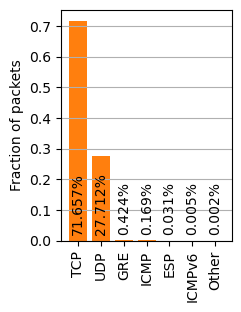

In [6]:
x = [counter.split("_")[0] for counter in pkt_counters_short.index]
y = pkt_counters_short.values / pkt_counters_short.sum()

fig, axes = plt.subplots(figsize=(2.2, 3))
axes.bar(np.arange(len(x)), y, color="C1")
axes.set_xticks(np.arange(len(x)))
axes.set_xticklabels(x, rotation=90)

for i, frac in enumerate(y):
    axes.text(i, 0.02, "{:.3%}".format(frac), ha="center", va="bottom", rotation=90)

axes.grid(axis="y")
axes.set_ylim(0)
axes.set_ylabel("Fraction of packets")
fig.savefig("figures/protocol_occurrence_packets.pdf", 
            dpi=300, bbox_inches="tight")
fig.savefig("figures/protocol_occurrence_packets.png", 
            dpi=300, bbox_inches="tight", transparent=True)

<a id="ecn-dist"></a>
### ECN distribution

In [7]:
ecn_counters = pd.read_hdf("data/processed/ecn_counters.hdf5")

ecn_counters.index = ecn_counters["timestamp"]
del ecn_counters["timestamp"]
ecn_counters.sort_index(inplace=True)

col_rename = {"no_ECT": "not-ECT", "ECT1": "ECT(1)", "ECT0": "ECT(0)"}
ecn_counters.rename(columns=col_rename, inplace=True)
ecn_counters = ecn_counters[["not-ECT", "ECT(0)", "ECT(1)", "CE"]]

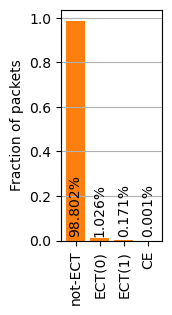

In [8]:
ecn_tot = ecn_counters.sum()
ecn_norm = ecn_tot / ecn_tot.sum()

fig, axes = plt.subplots(figsize=(1.3, 3))
axes.bar(np.arange(len(ecn_norm)), ecn_norm.values, color="C1")
axes.set_xticks(np.arange(len(ecn_norm)))
axes.set_xticklabels(ecn_norm.index, rotation=90)

for i, frac in enumerate(ecn_norm.values):
    axes.text(i, 0.02, "{:.3%}".format(frac), ha="center", va="bottom", rotation=90)

axes.grid(axis="y")
axes.set_ylim(0)
axes.set_ylabel("Fraction of packets")
fig.savefig("figures/ECN_occurrence_packets.pdf", 
            dpi=300, bbox_inches="tight")
fig.savefig("figures/ECN_occurrence_packets.png", 
            dpi=300, bbox_inches="tight", transparent=True)

In [9]:
ecn_marked = ecn_tot[["ECT(0)", "ECT(1)", "CE"]]
ecn_marked

ECT(0)    3656921536
ECT(1)     610762306
CE           2114690
dtype: int64

In [10]:
ecn_marked.sum() / ecn_tot.sum()

0.011983632096637107

In [11]:
ecn_marked["ECT(0)"] / ecn_marked.sum()

0.8564623151638668

In [12]:
ecn_marked["ECT(1)"] / ecn_marked.sum()

0.14304241790863026

In [13]:
ecn_marked["CE"] / ecn_marked.sum()

0.0004952669275028923

<a id="tcpts-dist"></a>
### TCP TS per subnet distribution

In [14]:
def make_subnet_agged_dataframe(stats_per_subnet):    
    subnets = list(stats_per_subnet.keys())
    records = [_flatten_merged_stats_record(stats_per_subnet[subnet]) 
               for subnet in subnets]
    
    df = pd.DataFrame.from_records(records)
    df.insert(0, "subnet", subnets)
    df.sort_values("subnet", inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # convert from ns to ms
    df["rtt_min"] /= 1e6
    df["rtt_max"] /= 1e6
    
    return df

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

def compute_rtt_metrics_for_hists(hists, bins, 
                                  metrics=["count", "mean", "median", "p95", "p99"], 
                                  histfunc_map=None):
    funcmap = {
        "count": bincount_count,
        "min": bincount_min,
        "mean": bincount_mean,
        "median": bincount_median,
        "p25": lambda b, c: bincount_quantile(b, c, 0.25),
        "p75": lambda b, c: bincount_quantile(b, c, 0.75),
        "p95": lambda b, c: bincount_quantile(b, c, 0.95),
        "p99": lambda b, c: bincount_quantile(b, c, 0.99),
        "p1p99": lambda b, c: bincount_quantile(b, c, 0.99) - bincount_quantile(b, c, 0.01),
        "max": bincount_max,
        "std": bincount_std,
        "iqr": bincount_iqr}

    
    if histfunc_map is not None:
        funcmap.update(histfunc_map)
    
    stats = {}
    for metric in metrics:
        stats["rtt_" + metric] = [funcmap[metric.lower()](bins, hist) 
                                  for hist in hists]

    return stats

def subnetstr_to_ip(subnet_str):
    return subnet_str.rsplit("/")[0]

In [15]:
%%time
with open("data/processed/subnet_stats_merged.json") as jfile:
    subnet_stats = json.load(jfile)

CPU times: user 4.61 s, sys: 412 ms, total: 5.02 s
Wall time: 5.02 s


In [16]:
%%time
df = make_subnet_agged_dataframe(subnet_stats)
wan_df = df.loc[np.logical_or(df["type"] == "WAN", df["subnet"].str.contains("/0"))].copy()

CPU times: user 5.19 s, sys: 225 ms, total: 5.42 s
Wall time: 5.42 s


In [17]:
%%time
wan_df["rtt_count"] = compute_rtt_metrics_for_hists(wan_df["rtt_hist"].values, 
                                                    bins=np.arange(0, 1001, 4), 
                                                    metrics=["count"])["rtt_count"]

CPU times: user 3.08 s, sys: 558 µs, total: 3.08 s
Wall time: 3.08 s


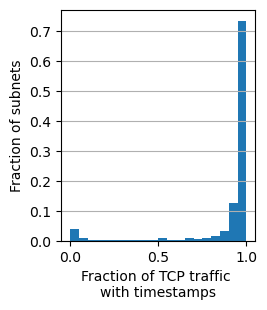

In [18]:
tot_tcp_ts = wan_df["tx_tcp_ts_packets"] + wan_df["rx_tcp_ts_packets"]
tot_tcp = wan_df["tx_tcp_packets"] + wan_df["rx_tcp_packets"]
ratio = tot_tcp_ts / tot_tcp

bins = np.arange(0, 1.001, 0.05)

fig, axes = plt.subplots(figsize=(2.5, 3))
counts, _ = np.histogram(ratio, bins=bins)
axes.bar(get_bin_centers(bins), counts / sum(counts), width=np.diff(bins))
axes.set_xlabel("Fraction of TCP traffic \nwith timestamps")
axes.set_ylabel("Fraction of subnets")
axes.grid(axis="y")
fig.savefig("figures/TCP_TS_WAN_fraction.pdf", bbox_inches="tight")

In [19]:
(ratio <= 0.1).sum() / len(ratio)

0.04689662330473291

In [20]:
(ratio >= 0.9).sum() / len(ratio)

0.8615070578466648

In [21]:
sel_subnets = wan_df["subnet"].values[ratio <= 0.1]
wan_df.loc[wan_df["subnet"].isin(sel_subnets)]["rtt_count"].sum() / wan_df["rtt_count"].sum()

0.0003685899315369176

In [22]:
sel_subnets = wan_df["subnet"].values[ratio <= 0.1]
sel_df = wan_df.loc[wan_df["subnet"].isin(sel_subnets)]
(sel_df["rx_tcp_packets"] + sel_df["tx_tcp_packets"]).sum() / (wan_df["rx_tcp_packets"] + wan_df["tx_tcp_packets"]).sum()

0.06847805641260837

In [23]:
sel_subnets = wan_df["subnet"].values[ratio >= 0.9]
wan_df.loc[wan_df["subnet"].isin(sel_subnets)]["rtt_count"].sum() / wan_df["rtt_count"].sum()

0.8772549735079004

<a id="lan-vs-wan"></a>
### Internal vs external latency

In [2]:
def _update_subnet_stats(to_stats, from_stats):
    to_stats["reports"] += from_stats["reports"]
    
    if from_stats["first_instance"] < to_stats["first_instance"]:
        to_stats["first_instance"] = from_stats["first_instance"]
    if from_stats["last_instance"] > to_stats["last_instance"]:
        to_stats["last_instance"] = from_stats["last_instance"]
    
    _update_rxtx_ttype_counters(to_stats["rx_stats"], from_stats["rx_stats"])
    _update_rxtx_ttype_counters(to_stats["tx_stats"], from_stats["tx_stats"])
    
    if from_stats["rtt_min"] is not None:
        if to_stats["rtt_min"] is None or from_stats["rtt_min"] < to_stats["rtt_min"]:
            to_stats["rtt_min"] = from_stats["rtt_min"]
        if to_stats["rtt_max"] is None or from_stats["rtt_max"] > to_stats["rtt_max"]:
            to_stats["rtt_max"] = from_stats["rtt_max"]
    
    add_to_histogram(to_stats["rtt_hist"], from_stats["rtt_hist"])

def _update_rxtx_ttype_counters(to_stats, from_stats):
    for ttype in from_stats.keys():
        
        if ttype in to_stats:
            for counter in from_stats[ttype]:
                to_stats[ttype][counter] += from_stats[ttype][counter]
        else:
            to_stats[ttype] = copy.deepcopy(from_stats[ttype])
    
    return to_stats

def _total_rxtx_ttype_counters(counters):
    pkt = 0
    byte = 0
    
    for ttype, counters in counters.items():
        pkt += counters.get("packets", 0)
        byte += counters.get("bytes", 0)
    
    return {"packets": pkt, "bytes": byte}

def merge_stats_for_subnet(subnet_data, target_subnet):
    subnets_merged = []
    subnet_stats = []
    target_subnet = ipaddress.ip_network(target_subnet)
    
    for subnet_str, stats in subnet_data.items():
        subnet = ipaddress.ip_network(subnet_str)
        if subnet.version == target_subnet.version and subnet.subnet_of(target_subnet):
            subnets_merged.append(subnet_str)
            subnet_stats.append(stats)
    
    merged_stats = merge_subnet_stats(subnet_stats)
    merged_stats["ip_version"] = target_subnet.version
    merged_stats["prefix_length"] = target_subnet.prefixlen
    merged_stats["merged_subnets"] = subnets_merged
    return merged_stats

def merge_subnet_stats(subnet_stats):
    merged_stats = _empty_subnet_stats()
    
    for stats in subnet_stats:
        _update_subnet_stats(merged_stats, stats)
    
    return merged_stats

def _empty_subnet_stats(nbins=250):
    return {"ip_version": 0,
            "prefix_length": 0,
            "type": "unknown",
            "reports": 0,
            "first_instance": 2**64 - 1,
            "last_instance": 0,
            "rx_stats": {},
            "tx_stats": {},
            "rtt_min": None,
            "rtt_max": None,
            "rtt_hist": [0] * nbins}

In [3]:
%%time
with open("data/processed/subnet_stats_merged.json", "rt") as f:
    subnet_data = json.load(f)

CPU times: user 4.65 s, sys: 546 ms, total: 5.2 s
Wall time: 5.41 s


In [4]:
# Number of aggregated entries (i.e. subnet histograms)
# Slightly lower than reported in paper due to merging/removing internal subnet records
tot_reports = sum((entry["reports"] for entry in subnet_data.values()))
tot_reports / 1e6

350.370438

In [5]:
# Total number of RTTs in histograms
tot_rtts = sum((sum(entry["rtt_hist"]) for entry in subnet_data.values()))
tot_rtts / 1e9

9.024982304

In [6]:
lan_subnets = [net for net, stats in subnet_data.items() 
               if stats["type"] == "LAN"]
lan_stats = merge_subnet_stats(subnet_data[net] for net in lan_subnets)
lan_stats["subnets"] = lan_subnets

wan_subnets = [net for net, stats in subnet_data.items() 
               if stats["type"] == "WAN" or net.endswith("/0")]
wan_stats = merge_subnet_stats(subnet_data[net] for net in wan_subnets)
wan_stats["subnets"] = wan_subnets

lan_rtts = sum(lan_stats["rtt_hist"])
wan_rtts = sum(wan_stats["rtt_hist"])

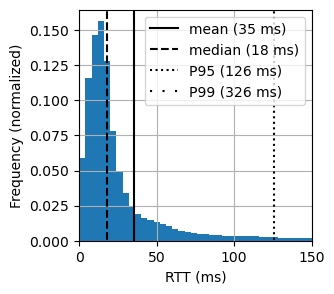

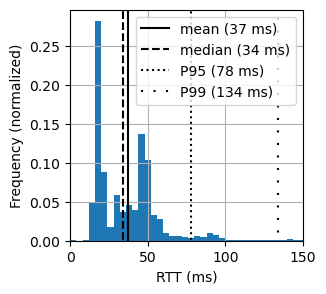

In [7]:
bins = np.arange(0, 1001, 4)

for netside, stats in zip(("LAN", "WAN"), (lan_stats, wan_stats)):
    counts = np.array(stats["rtt_hist"])
    n = sum(counts)

    fig, axes = plt.subplots(figsize=(3, 3))
    axes.bar(get_bin_centers(bins), counts / n, width=np.diff(bins))

    ylim = axes.get_ylim()
    for func, name, ls in zip((bincount_mean, bincount_median, 
                                  lambda b, c: bincount_quantile(b, c, 0.95),
                                  lambda b, c: bincount_quantile(b, c, 0.99)), 
                                 ("mean", "median", "P95", "P99"), ("-", "--", ":", (0, (1, 5)))):
        x = func(bins, counts)
        axes.plot([x, x], [-1e99, 1e99], c="k", ls=ls, label="{} ({:.0f} ms)".format(name, x))
    axes.set_ylim(*ylim)


    axes.legend(loc="upper right")
    axes.grid()

    axes.set_ylabel("Frequency (normalized)")
    axes.set_xlabel("RTT (ms)")
    axes.set_xlim(0, 150)
    
    fig.savefig("figures/RTT_hist_{}_all.pdf".format(netside), dpi=300, bbox_inches="tight")

In [8]:
# Internal RTTs < 12 ms
sum(lan_stats["rtt_hist"][:3]) / sum(lan_stats["rtt_hist"])

0.3216012622090644

In [9]:
# Internal RTTs >= 996 ms
lan_stats["rtt_hist"][-1] / sum(lan_stats["rtt_hist"])

0.001596501347165299

In [10]:
# External RTTs <= 24ms
sum(wan_stats["rtt_hist"][:6]) / sum(wan_stats["rtt_hist"])

0.4203813328786081

In [11]:
%%time
merged_stats = {}
for ip_version, netsep in zip((4, 6), (".", ":")):
    subnets = [net for net, stats in subnet_data.items() 
               if stats["type"] == "LAN" and netsep in net]
    ipstats = merge_subnet_stats(subnet_data[net] for net in subnets)
    ipstats["subnets"] = subnets
    merged_stats["LAN-" + str(ip_version)] = ipstats
    
    subnets = [net for net, stats in subnet_data.items() 
               if (stats["type"] == "WAN" or net.endswith("/0")) and netsep in net]
    ipstats = merge_subnet_stats(subnet_data[net] for net in subnets)
    ipstats["subnets"] = subnets
    merged_stats["WAN-" + str(ip_version)] = ipstats

CPU times: user 3.92 s, sys: 107 µs, total: 3.92 s
Wall time: 3.91 s


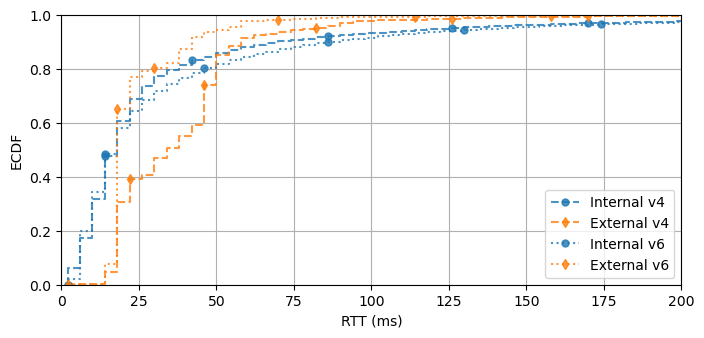

In [24]:
bins = np.arange(0, 1000.01, 4)
fig, axes = plt.subplots(figsize=(8, 3.5))

for ip_version, ls in zip((4, 6), ("--", ":")):
    for netside, c, marker in zip(("LAN", "WAN"), ("C0", "C1"), ("o", "d")):
        
        counts = merged_stats[netside + "-" + str(ip_version)]["rtt_hist"]
        label = ("Internal" if netside == "LAN" else "External") + " v" + str(ip_version)
        plot_ecdf(*bincount_ecdf(bins, counts), axes=axes, c=c, ls=ls, marker=marker,
                  markersize=5, markevery=0.2, alpha=0.8, label=label)
                  #label="{} v{} ({:.2%})".format(netside, ip_version, sum(counts) / n_rtts))

axes.legend()
axes.grid(which="major")
axes.grid(which="minor", alpha=0.3)
axes.set_ylim(0, 1)
axes.set_ylabel("ECDF")
#axes.set_xscale("log")
axes.set_xlim(0, 200)
axes.set_xlabel("RTT (ms)")

fig.savefig("figures/RTT_CDF_per_sideandversion-wide.pdf", dpi=300, bbox_inches="tight")

<a id="tcpts-pktcount-table"></a>
### TCP TS packet and RTT counts table

In [35]:
def _update_subnet_stats(to_stats, from_stats):
    to_stats["reports"] += from_stats["reports"]
    
    if from_stats["first_instance"] < to_stats["first_instance"]:
        to_stats["first_instance"] = from_stats["first_instance"]
    if from_stats["last_instance"] > to_stats["last_instance"]:
        to_stats["last_instance"] = from_stats["last_instance"]
    
    _update_rxtx_ttype_counters(to_stats["rx_stats"], from_stats["rx_stats"])
    _update_rxtx_ttype_counters(to_stats["tx_stats"], from_stats["tx_stats"])
    
    if from_stats["rtt_min"] is not None:
        if to_stats["rtt_min"] is None or from_stats["rtt_min"] < to_stats["rtt_min"]:
            to_stats["rtt_min"] = from_stats["rtt_min"]
        if to_stats["rtt_max"] is None or from_stats["rtt_max"] > to_stats["rtt_max"]:
            to_stats["rtt_max"] = from_stats["rtt_max"]
    
    add_to_histogram(to_stats["rtt_hist"], from_stats["rtt_hist"])

def _update_rxtx_ttype_counters(to_stats, from_stats):
    for ttype in from_stats.keys():
        
        if ttype in to_stats:
            for counter in from_stats[ttype]:
                to_stats[ttype][counter] += from_stats[ttype][counter]
        else:
            to_stats[ttype] = copy.deepcopy(from_stats[ttype])
    
    return to_stats

def _total_rxtx_ttype_counters(counters):
    pkt = 0
    byte = 0
    
    for ttype, counters in counters.items():
        pkt += counters.get("packets", 0)
        byte += counters.get("bytes", 0)
    
    return {"packets": pkt, "bytes": byte}

def merge_stats_for_subnet(subnet_data, target_subnet):
    subnets_merged = []
    subnet_stats = []
    target_subnet = ipaddress.ip_network(target_subnet)
    
    for subnet_str, stats in subnet_data.items():
        subnet = ipaddress.ip_network(subnet_str)
        if subnet.version == target_subnet.version and subnet.subnet_of(target_subnet):
            subnets_merged.append(subnet_str)
            subnet_stats.append(stats)
    
    merged_stats = merge_subnet_stats(subnet_stats)
    merged_stats["ip_version"] = target_subnet.version
    merged_stats["prefix_length"] = target_subnet.prefixlen
    merged_stats["merged_subnets"] = subnets_merged
    return merged_stats

def merge_subnet_stats(subnet_stats):
    merged_stats = _empty_subnet_stats()
    
    for stats in subnet_stats:
        _update_subnet_stats(merged_stats, stats)
    
    return merged_stats

def _empty_subnet_stats(nbins=250):
    return {"ip_version": 0,
            "prefix_length": 0,
            "type": "unknown",
            "reports": 0,
            "first_instance": 2**64 - 1,
            "last_instance": 0,
            "rx_stats": {},
            "tx_stats": {},
            "rtt_min": None,
            "rtt_max": None,
            "rtt_hist": [0] * nbins}

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

In [36]:
with open("data/processed/subnet_stats_merged.json") as jfile:
    subnet_stats = json.load(jfile)

In [37]:
lan4_subnets = [subnet for subnet, stats in subnet_stats.items() 
                if stats["ip_version"] == 4 and stats["type"] == "LAN"]
lan4_stats = _flatten_merged_stats_record(
    merge_subnet_stats((subnet_stats[subnet] for subnet in lan4_subnets)))
lan4_stats["subnets"] = lan4_subnets

lan6_subnets = [subnet for subnet, stats in subnet_stats.items() 
                if stats["ip_version"] == 6 and stats["type"] == "LAN"]
lan6_stats = _flatten_merged_stats_record(
    merge_subnet_stats((subnet_stats[subnet] for subnet in lan6_subnets)))
lan6_stats["subnets"] = lan6_subnets

wan4_subnets = [subnet for subnet, stats in subnet_stats.items() 
                if stats["ip_version"] == 4 and 
                (stats["type"] == "WAN" or subnet.endswith("0/0"))]
wan4_stats = _flatten_merged_stats_record(
    merge_subnet_stats((subnet_stats[subnet] for subnet in wan4_subnets)))
wan4_stats["subnets"] = wan4_subnets

wan6_subnets = [subnet for subnet, stats in subnet_stats.items() 
                if stats["ip_version"] == 6 and 
                (stats["type"] == "WAN" or subnet.endswith(":/0"))]
wan6_stats = _flatten_merged_stats_record(
    merge_subnet_stats((subnet_stats[subnet] for subnet in wan6_subnets)))
wan6_stats["subnets"] = wan6_subnets

In [38]:
ipv4vs6_table = []
for ipv, lan_stats, wan_stats in zip(("IPv4", "IPv6"), 
                                     (lan4_stats, lan6_stats), 
                                     (wan4_stats, wan6_stats)):
    for trafdir, trafdir_pretty in zip(("tx", "rx"), ("Downlink", "Uplink")):

        ipv4vs6_table.append({"IP": ipv, "Direction": trafdir_pretty, 
                              "Packets": lan_stats[trafdir + "_tcp_ts_packets"], 
                              "Bytes": lan_stats[trafdir + "_tcp_ts_bytes"],
                              "RTTs": (sum(lan_stats["rtt_hist"]) if trafdir == "tx" 
                                       else sum(wan_stats["rtt_hist"]))})

ipv4vs6_table = pd.DataFrame.from_records(ipv4vs6_table)

for col in ("Packets", "Bytes", "RTTs"):
    ipv4vs6_table[col + " (%)"] = 100 * ipv4vs6_table[col] / ipv4vs6_table[col].sum()

for col, unit, factor in zip(("Packets", "Bytes", "RTTs"), 
                             ("G", "T", "G"), 
                             (1e9, 1e12, 1e9)):
    ipv4vs6_table[col] /= factor
    ipv4vs6_table.rename(columns={col: f"# {col} ({unit})"}, inplace=True)
    
ipv4vs6_table

,IP,Direction,# Packets (G),# Bytes (T),# RTTs (G),Packets (%),Bytes (%),RTTs (%)
0,IPv4,Downlink,131.990457,185.314706,5.481082,59.685451,83.338476,60.732328
1,IPv4,Uplink,66.830687,13.112442,2.778931,30.220516,5.896839,30.791543
2,IPv6,Downlink,16.736813,22.373740,0.527931,7.568306,10.061767,5.849662
3,IPv6,Uplink,5.585478,1.563035,0.237038,2.525727,0.702918,2.626467


In [39]:
# With multicolumns as well
cols_as_tuples = [("Packets", "Billions"), ("Bytes", "Trillions"), ("RTTs", "Billions"), 
               ("Packets", "%"), ("Bytes", "%"), ("RTTs", "%")]
cols_grouped = [None] * len(cols_as_tuples)
cols_grouped[0::2] = cols_as_tuples[:3]
cols_grouped[1::2] = cols_as_tuples[3:]

tab = ipv4vs6_table.groupby(["Direction", "IP"]).sum()
tab.columns = cols_as_tuples
tab = tab[cols_grouped]
tab.columns = pd.MultiIndex.from_tuples(tab.columns)
tab

Packets                  Bytes                 RTTs  \
                  Billions          %   Trillions          %  Billions   
Direction IP                                                             
Downlink  IPv4  131.990457  59.685451  185.314706  83.338476  5.481082   
          IPv6   16.736813   7.568306   22.373740  10.061767  0.527931   
Uplink    IPv4   66.830687  30.220516   13.112442   5.896839  2.778931   
          IPv6    5.585478   2.525727    1.563035   0.702918  0.237038   

                           
                        %  
Direction IP               
Downlink  IPv4  60.732328  
          IPv6   5.849662  
Uplink    IPv4  30.791543  
          IPv6   2.626467

In [40]:
print(tab.to_latex(multicolumn=True, multicolumn_format="c", multirow=True, float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
       &      & \multicolumn{2}{c}{Packets} & \multicolumn{2}{c}{Bytes} & \multicolumn{2}{c}{RTTs} \\
       &      & Billions &     \% & Trillions &     \% & Billions &     \% \\
Direction & IP &          &       &           &       &          &       \\
\midrule
\multirow{2}{*}{Downlink} & IPv4 &   131.99 & 59.69 &    185.31 & 83.34 &     5.48 & 60.73 \\
       & IPv6 &    16.74 &  7.57 &     22.37 & 10.06 &     0.53 &  5.85 \\
\cline{1-8}
\multirow{2}{*}{Uplink} & IPv4 &    66.83 & 30.22 &     13.11 &  5.90 &     2.78 & 30.79 \\
       & IPv6 &     5.59 &  2.53 &      1.56 &  0.70 &     0.24 &  2.63 \\
\bottomrule
\end{tabular}



<a id="rtt-timeseries"></a>
### RTT timeseries

In [2]:
def timestamp_to_datetime(timestamps, timezone=None):
    dt = pd.to_datetime(timestamps, unit="ns", utc=True)
    if timezone is not None:
        dt = dt.tz_convert(timezone)
    
    return dt

def make_timeagged_dataframe(stats_per_time, tz=None):
    records = [_flatten_merged_stats_record(entry) 
               for entry in stats_per_time.values()]
    
    ts = [int(t) for t in stats_per_time.keys()]
    index = timestamp_to_datetime(ts, timezone=tz)
    
    df = pd.DataFrame.from_records(records, index=index)
    df.sort_index(inplace=True)
    
    # convert from ns to ms
    df["rtt_min"] /= 1e6
    df["rtt_max"] /= 1e6
    
    return df

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

def compute_rtt_metrics_for_hists(hists, bins, 
                                  metrics=["count", "mean", "median", "p95", "p99"], 
                                  histfunc_map=None):
    funcmap = {
        "count": bincount_count,
        "min": bincount_min,
        "mean": bincount_mean,
        "median": bincount_median,
        "p25": lambda b, c: bincount_quantile(b, c, 0.25),
        "p75": lambda b, c: bincount_quantile(b, c, 0.75),
        "p95": lambda b, c: bincount_quantile(b, c, 0.95),
        "p99": lambda b, c: bincount_quantile(b, c, 0.99),
        "max": bincount_max,
        "std": bincount_std,
        "iqr": bincount_iqr
    }
    
    if histfunc_map is not None:
        funcmap.update(histfunc_map)
    
    stats = {}
    for metric in metrics:
        stats["rtt_" + metric] = [funcmap[metric.lower()](bins, hist) 
                                  for hist in hists]
    
    return stats

def resample_timeagg_df(df, freq, freq_offset=None, 
                        rtt_metrics=None, bins=None, **kwargs):
    resamp = df.resample(freq, **kwargs)
    
    pktbyte_cols = [col for col in df.columns 
                    if col.startswith("tx_") or col.startswith("rx_")]
    new_df = resamp[pktbyte_cols].sum()
    new_df["rtt_min"] = resamp["rtt_min"].min()
    new_df["rtt_max"] = resamp["rtt_max"].min()
    new_df["rtt_hist"] = resamp["rtt_hist"].apply(sum_histograms)
    
    if rtt_metrics is not None and bins is not None:
        for stat, vals in compute_rtt_metrics_for_hists(
            new_df["rtt_hist"], bins, rtt_metrics).items():
            
            if stat not in ["rtt_min", "rtt_max"]:
                new_df[stat] = vals
    
    if freq_offset is not None:
        new_df.index = new_df.index + to_offset(freq_offset)
    
    return new_df

def make_rtt_vs_throughput_graph(df, freq, centering_freq, sec_per_freq, 
                                 rtt_metrics=["mean", "median", "p95"], 
                                 plot_throughput=True, throughput_type="bps", 
                                 throughput_prefix="G", downlink="tx", 
                                 figsize=(30, 5), hour_ticks=(0, 8, 16), 
                                 minor_ticks=True, bins=np.arange(0, 1001, 4),
                                 rtt_ylim=(0, 250), throughput_ylim=0,
                                 rtt_hist=True, hist_width=0.1, 
                                 rtt_line_kwargs={}, throughput_line_kwargs={},
                                 legend=True, legend_kwargs={}):
    if throughput_type not in ("bps", "pps"):
        raise ValueError("throughput_type must be 'bps' or 'pps'")
    prefix_mod = {None: 1, "": 1, "k": 1e3, "M": 1e6, "G": 1e9, "T": 1e12}
    
    data = resample_timeagg_df(df, freq, freq_offset=centering_freq, 
                               rtt_metrics=rtt_metrics, bins=bins)
    tz = data.index.tz
    
    fig, ax = plt.subplots(figsize=figsize)
    hist_ax = None
    if rtt_hist:
        hist_ax = ax.inset_axes([-hist_width, 0, hist_width, 1], sharey=ax)
        ax.tick_params(axis="y", labelleft=False)
        #hist_ax.tick_params(axis="x", labelbottom=False)
        

    # Plot RTTs
    if isinstance(rtt_line_kwargs, dict):
        rtt_line_kwargs = [rtt_line_kwargs] * len(rtt_metrics)
    for metric, kws in zip(rtt_metrics, rtt_line_kwargs):
        ax.plot(data.index, data["rtt_" + metric].values, 
                label="RTT " + metric, **kws)
        
        if hist_ax:
            hist_ax.hist(data["rtt_" + metric].values, bins=bins, alpha=0.5, 
                         orientation="horizontal")
    
    ax.grid()
    ax.set_ylim(rtt_ylim)
    leg_axes = [ax]
    
    if hist_ax:
        hist_ax.set_xlim(hist_ax.get_xlim()[::-1])
        hist_ax.set_xticks([])
        hist_ax.grid(axis="y")
        #ax.set_yticklabels([])
        hist_ax.set_ylabel("RTT (ms)")
    else:
        ax.set_ylabel("RTT (ms)")
    
    # Plot throughputs
    if plot_throughput:
        ax2 = ax.twinx()
        ax.set_zorder(ax2.get_zorder() + 1)
        ax.set_frame_on(False)
        leg_axes.append(ax2)
        
        if throughput_type == "bps":
            ct = "bytes"
            type_mult = 8
        else:
            ct = "packets"
            type_mult = 1 / 1e6
        tp_mult = type_mult / sec_per_freq / prefix_mod[throughput_prefix]

        if downlink == "tx":
            dl_col = "tx_"
            ul_col = "rx_"
        else:
            dl_col = "rx_"
            ul_col = "tx_"

        ax2.plot(data.index, data[dl_col + ct].values * tp_mult, "k--", 
                 label="Downlink", **throughput_line_kwargs)
        ax2.plot(data.index, data[ul_col + ct].values * tp_mult, "k:", 
                 label="Uplink", **throughput_line_kwargs)
        
        ax2.set_ylim(throughput_ylim)
        ax2.set_ylabel("Average throughput ({}{})".format(throughput_prefix, 
                                                          throughput_type))

    # Plot formatting
    locator = mdates.HourLocator(byhour=hour_ticks, tz=tz)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.HourLocator(tz=tz))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70, 
             ha="right", rotation_mode="anchor")

    if legend:
        ax.legend(*_combine_legends(leg_axes), **legend_kwargs)
    
    return data, fig

def _combine_legends(axes):
    handles = []
    labels = []
    for ax in axes:
        hand, lab = ax.get_legend_handles_labels()
        handles.extend(hand)
        labels.extend(lab)
    
    return handles, labels

def add_inset_histogram(axes, vals, axis="x", histheight=0.25, spacing=0.05, **kwargs):
    if axis not in ("x", "y"):
        raise ValueError("axis must be 'x' or 'y'")
    
    if axis == "x":
        histaxes = axes.inset_axes([0, 1 + spacing, 1, histheight], sharex=axes)
        histaxes.tick_params(axis="x", labelbottom=False)
        orientation = "vertical"
    else:
        histaxes = axes.inset_axes([1 + spacing, 0, histheight, 1], sharey=axes)
        histaxes.tick_params(axis="y", labelleft=False)
        orientation = "horizontal"
    
    histaxes.hist(vals, orientation=orientation, **kwargs)
    
    return histaxes

In [3]:
with open("data/processed/lan_per10s_stats_merged.json") as jfile:
    lan_stats_per10s = json.load(jfile)

In [4]:
%%time
lan_stats = make_timeagged_dataframe(lan_stats_per10s, tz="US/Mountain")

bins = np.arange(0, 1001, 4)
for rtt_stat, vals in compute_rtt_metrics_for_hists(
    lan_stats["rtt_hist"], bins).items():
    lan_stats[rtt_stat] = vals

CPU times: user 1min 17s, sys: 375 ms, total: 1min 17s
Wall time: 1min 17s


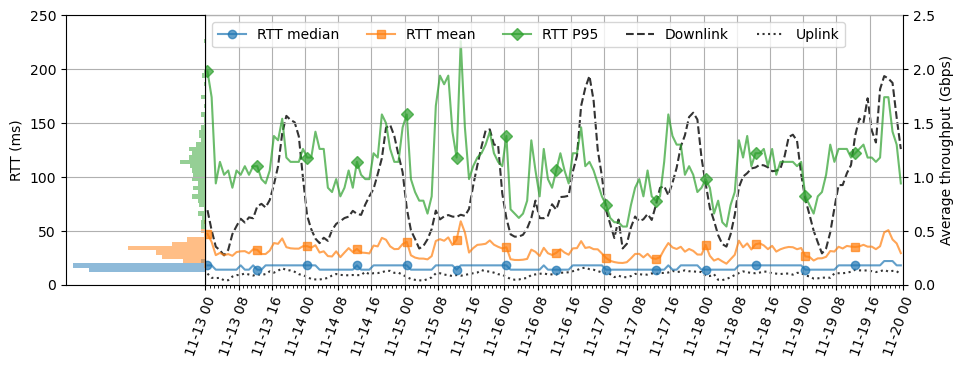

In [44]:
start_date = "2023-11-13T00:00-07:00"
end_date = "2023-11-20T00:00-07:00"
sel_period = lan_stats.query("index >= @start_date and index <= @end_date")

freq = "1h"
half_freq = "30min"
sec_per_freq = 3600

line_kwargs = [{"marker": mark, "markevery": 12, "alpha": 0.7} 
               for mark in ("o", "s", "D")]

data, fig = make_rtt_vs_throughput_graph(sel_period, freq, half_freq, sec_per_freq, 
                                         rtt_metrics=["median", "mean", "P95"],
                                         rtt_ylim=(0, 250), throughput_ylim=(0, 2.5),
                                         figsize=(9, 3.5), hist_width=0.2,
                                         rtt_line_kwargs=line_kwargs,
                                         throughput_line_kwargs={"alpha": 0.8},
                                         legend_kwargs={"ncol": 5, "loc": "upper left"})

fig.get_axes()[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

fig.savefig("figures/LAN_RTT_timeseries_oneweek_{}-compact.pdf".format(freq), 
            bbox_inches="tight")
fig.savefig("figures/LAN_RTT_timeseries_oneweek_{}-compact.png".format(freq), 
            bbox_inches="tight", dpi=300, transparent=True)

In [45]:
with open("data/processed/wan_per10s_stats_merged.json") as jfile:
    wan_stats_per10s = json.load(jfile)

In [46]:
%%time
wan_stats = make_timeagged_dataframe(wan_stats_per10s, tz="US/Mountain")

bins = np.arange(0, 1001, 4)
for rtt_stat, vals in compute_rtt_metrics_for_hists(
    wan_stats["rtt_hist"], bins).items():
    wan_stats[rtt_stat] = vals

CPU times: user 1min 16s, sys: 399 ms, total: 1min 17s
Wall time: 1min 17s


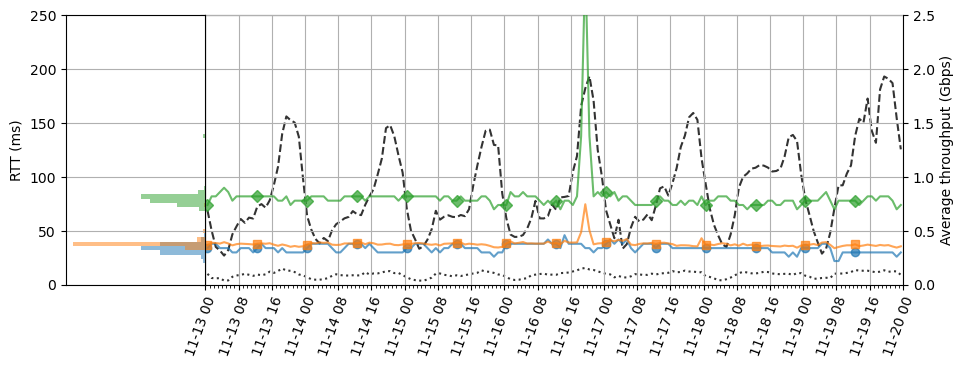

In [47]:
start_date = "2023-11-13T00:00-07:00"
end_date = "2023-11-20T00:00-07:00"
sel_period = wan_stats.query("index >= @start_date and index <= @end_date")

freq = "1h"
half_freq = "30min"
sec_per_freq = 3600

line_kwargs = [{"marker": mark, "markevery": 12, "alpha": 0.7} 
               for mark in ("o", "s", "D")]

data, fig = make_rtt_vs_throughput_graph(sel_period, freq, half_freq, sec_per_freq, 
                                         rtt_metrics=["median", "mean", "P95"], 
                                         figsize=(9, 3.5), hist_width=0.2,
                                         rtt_line_kwargs=line_kwargs,
                                         throughput_line_kwargs={"alpha": 0.8},
                                         throughput_ylim=(0, 2.5),
                                         #legend_kwargs={"ncol": 5, "loc": "upper left"},
                                         legend=False,
                                         downlink="rx")
fig.get_axes()[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

fig.savefig("figures/WAN_RTT_timeseries_oneweek_{}-compact.pdf".format(freq), 
            bbox_inches="tight")
fig.savefig("figures/WAN_RTT_timeseries_oneweek_{}-compact.png".format(freq), 
            bbox_inches="tight", transparent=True, dpi=400)

(19678.041666666668, 19678.166666666668)

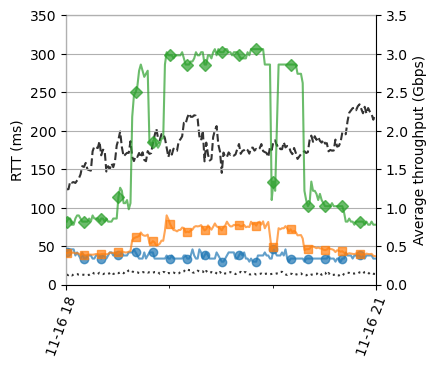

In [48]:
# Some temprorary WAN RTT spikes
start_date = "2023-11-16T18:00-07:00"
end_date = "2023-11-16T21:00-07:00"
sel_period = wan_stats.query("index >= @start_date and index <= @end_date")

freq = "1min"
half_freq = "30s"
sec_per_freq = 60

line_kwargs = [{"marker": mark, "markevery": 10, "alpha": 0.7} 
               for mark in ("o", "s", "D")]

data, fig = make_rtt_vs_throughput_graph(sel_period, freq, half_freq, sec_per_freq, 
                                         rtt_metrics=["median", "mean", "P95"], 
                                         figsize=(4, 3.5), rtt_hist=False,
                                         rtt_line_kwargs=line_kwargs,
                                         throughput_line_kwargs={"alpha": 0.8},
                                         #legend_kwargs={"ncol": 5, "loc": "upper left"},
                                         rtt_ylim=(0, 350), throughput_ylim=(0, 3.5),
                                         legend=False,
                                         downlink="rx")
fig.get_axes()[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

(0.0, 2.5)

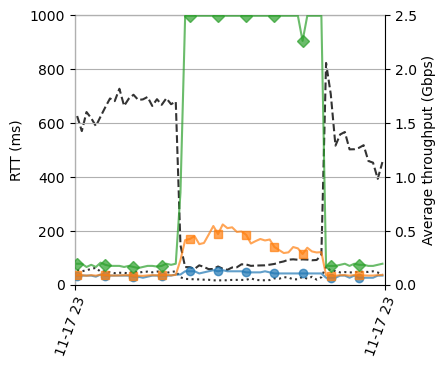

In [49]:
start_date = "2023-11-17T23:04-07:00"
end_date = "2023-11-17T23:15-07:00"
sel_period = wan_stats.query("index >= @start_date and index <= @end_date")

freq = "10s"
half_freq = "5s"
sec_per_freq = 10

line_kwargs = [{"marker": mark, "markevery": 6, "alpha": 0.7} 
               for mark in ("o", "s", "D")]

data, fig = make_rtt_vs_throughput_graph(sel_period, freq, half_freq, sec_per_freq, 
                                         rtt_metrics=["median", "mean", "P95"], 
                                         figsize=(4, 3.5), rtt_hist=False,
                                         rtt_line_kwargs=line_kwargs,
                                         throughput_line_kwargs={"alpha": 0.8},
                                         #legend_kwargs={"ncol": 5, "loc": "upper left"},
                                         rtt_ylim=(0, 1000), throughput_ylim=(0, 2.5),
                                         legend=False,
                                         downlink="rx")
fig.get_axes()[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
fig.get_axes()[1].set_ylim(0, 2.5)

<a id="rtt-correlation"></a>
### RTT correlation

In [2]:
def timestamp_to_datetime(timestamps, timezone=None):
    dt = pd.to_datetime(timestamps, unit="ns", utc=True)
    if timezone is not None:
        dt = dt.tz_convert(timezone)
    
    return dt

def make_timeagged_dataframe(stats_per_time, tz=None):
    records = [_flatten_merged_stats_record(entry) 
               for entry in stats_per_time.values()]
    
    ts = [int(t) for t in stats_per_time.keys()]
    index = timestamp_to_datetime(ts, timezone=tz)
    
    df = pd.DataFrame.from_records(records, index=index)
    df.sort_index(inplace=True)
    
    # convert from ns to ms
    df["rtt_min"] /= 1e6
    df["rtt_max"] /= 1e6
    
    return df

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

def compute_rtt_metrics_for_hists(hists, bins, 
                                  metrics=["count", "mean", "median", "p95", "p99"], 
                                  histfunc_map=None):
    funcmap = {
        "count": bincount_count,
        "min": bincount_min,
        "mean": bincount_mean,
        "median": bincount_median,
        "p25": lambda b, c: bincount_quantile(b, c, 0.25),
        "p75": lambda b, c: bincount_quantile(b, c, 0.75),
        "p95": lambda b, c: bincount_quantile(b, c, 0.95),
        "p99": lambda b, c: bincount_quantile(b, c, 0.99),
        "max": bincount_max,
        "std": bincount_std,
        "iqr": bincount_iqr
    }
    
    if histfunc_map is not None:
        funcmap.update(histfunc_map)
    
    stats = {}
    for metric in metrics:
        stats["rtt_" + metric] = [funcmap[metric.lower()](bins, hist) 
                                  for hist in hists]
    
    return stats

def resample_timeagg_df(df, freq, freq_offset=None, 
                        rtt_metrics=None, bins=None, **kwargs):
    resamp = df.resample(freq, **kwargs)
    
    pktbyte_cols = [col for col in df.columns 
                    if col.startswith("tx_") or col.startswith("rx_")]
    new_df = resamp[pktbyte_cols].sum()
    new_df["rtt_min"] = resamp["rtt_min"].min()
    new_df["rtt_max"] = resamp["rtt_max"].min()
    new_df["rtt_hist"] = resamp["rtt_hist"].apply(sum_histograms)
    
    if rtt_metrics is not None and bins is not None:
        for stat, vals in compute_rtt_metrics_for_hists(
            new_df["rtt_hist"], bins, rtt_metrics).items():
            
            if stat not in ["rtt_min", "rtt_max"]:
                new_df[stat] = vals
    
    if freq_offset is not None:
        new_df.index = new_df.index + to_offset(freq_offset)
    
    return new_df

def plot_correlation_heatmap(df, axes=None, precomputed=False, method="spearman", 
                             vmin=-1, vmax=1, cmap="bwr", val_fmt=".2f", **kwargs):
    if axes is None:
        axes = plt.gca()
    
    if precomputed:
        x = df
    else:
        x = df.corr(method=method)
    
    plot_heatmap(x.values, axes=axes, cmap=cmap, vmin=vmin, vmax=vmax, 
                 val_fmt=val_fmt, **kwargs)
    
    axes.xaxis.tick_top()
    axes.set_xticks(np.arange(len(x)))
    axes.set_xticklabels(x.columns, rotation=45, va="bottom", ha="left", 
                         rotation_mode="anchor")
    axes.set_yticks(np.arange(len(x)))
    axes.set_yticklabels(x.columns)
    
    return x

def make_rtt_corr_df(df, freq, rtt_metrics=["count", "min", "p25", "median", "mean", 
                                      "p75", "p95", "p99", "max", "iqr", "std"],
                    bins=np.arange(0, 1001, 4), figsize=(10, 10), **kwargs):
    
    data = resample_timeagg_df(df, freq, rtt_metrics=rtt_metrics, bins=bins)

    for col in data.columns:
        if not col.startswith("rx_"):
            continue

        trafcol = col[3:]
        data["tot_" + trafcol] = data["rx_" + trafcol] + data["tx_" + trafcol]

    corr_cols = ([col for col in data.columns 
                 if col.startswith("rx_") or col.startswith("tx_") or 
                  col.startswith("tot_")] +
                 ["rtt_" + metric for metric in rtt_metrics])

    fig, axes = plt.subplots(figsize=figsize)
    corr = plot_correlation_heatmap(data[corr_cols], axes=axes, **kwargs)
    return corr, fig

In [3]:
%%time

with open("data/processed/lan_per10s_stats_merged.json") as jfile:
    lan_stats_per10s = json.load(jfile)
    
lan_stats = make_timeagged_dataframe(lan_stats_per10s, tz="US/Mountain")


with open("data/processed/wan_per10s_stats_merged.json") as jfile:
    wan_stats_per10s = json.load(jfile)

wan_stats = make_timeagged_dataframe(wan_stats_per10s, tz="US/Mountain")

CPU times: user 34.9 s, sys: 2.82 s, total: 37.8 s
Wall time: 38.7 s


In [4]:
%%time
freq = "10s"
bins = np.arange(0, 1001, 4)
rtt_metrics = ["count", "min", "p25", "median", "mean", 
               "p75", "p95", "p99", "max", "iqr", "std"]

lan_agg = resample_timeagg_df(lan_stats, freq, rtt_metrics=rtt_metrics, bins=bins)
wan_agg = resample_timeagg_df(wan_stats, freq, rtt_metrics=rtt_metrics, bins=bins)

CPU times: user 7min 7s, sys: 881 ms, total: 7min 8s
Wall time: 7min 8s


/home/simon/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


CPU times: user 15.7 s, sys: 1.36 s, total: 17.1 s
Wall time: 15.2 s


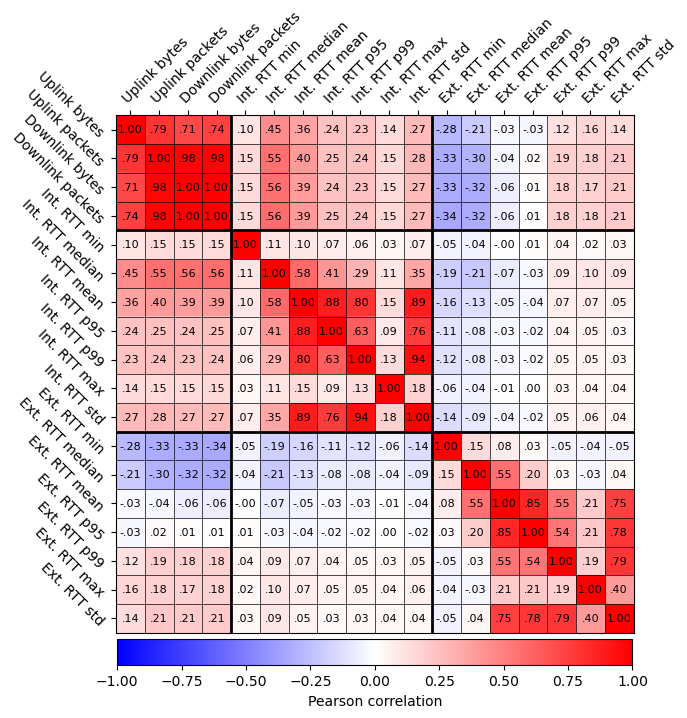

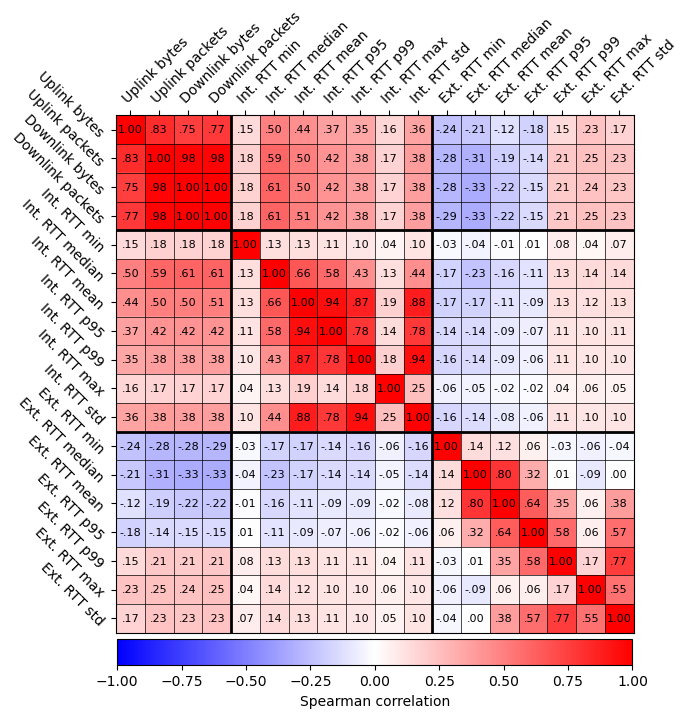

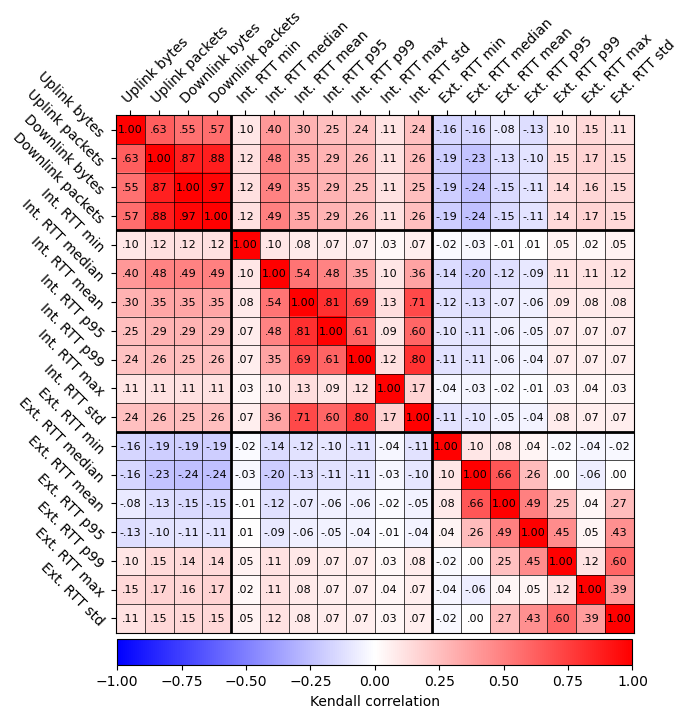

In [5]:
%%time
# Narrow version
# https://stackoverflow.com/questions/10303797/print-floating-point-values-without-leading-zero
fmt_float_skipzero = lambda x: ("%.2f" % x).replace("-0", "-").lstrip("0")


traf_cols = ["rx_bytes", "rx_packets", "tx_bytes", "tx_packets"]
rtt_cols = ["rtt_" + col for col in ["min", "median", "mean", "p95", "p99", "max", "std"]]

comb_agg = lan_agg[traf_cols + rtt_cols].join(wan_agg[rtt_cols], how="inner",
                                              lsuffix="_lan", rsuffix="_wan")

rename_cols = {}
for col in traf_cols:
    tdir, ttype = col.split("_")
    rename_cols[col] = ("Uplink" if tdir == "rx" else "Downlink") + " " + ttype

for col in [col for col in comb_agg.columns if col.startswith("rtt_")]:
    _, metric, side = col.split("_")
    side = "Int." if side == "lan" else "Ext."
    rename_cols[col] = side + " RTT " + metric

comb_agg.rename(columns=rename_cols, inplace=True)

for method in ("pearson", "spearman", "kendall"):
    fig, axes = plt.subplots(figsize=(7, 8))
    plot_correlation_heatmap(comb_agg, axes=axes, method=method, 
                             cbar_label=method.capitalize() + " correlation",
                             fontsize=8, val_fmt=fmt_float_skipzero,
                             cbar_kwargs={"location": "bottom", "pad": 0.01, 
                                          "shrink": 0.95})
    
    axes.set_yticklabels(axes.get_yticklabels(), rotation=-45, rotation_mode="anchor", va="top", ha="right")
    
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    for breakpoint in [len(traf_cols), len(traf_cols) + len(rtt_cols)]:
        axes.plot([breakpoint - 0.5] * 2, ylim, "k-", linewidth=2)
        axes.plot(xlim, [breakpoint - 0.5] * 2, "k-", linewidth=2)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    
    fig.savefig("figures/RTT_LANWAN_corrheatmap_10s_{}_narrow.pdf".format(method), 
                dpi=300, bbox_inches="tight")

In [6]:
%%time
freqs = ["10s", "1min", "10min", "1h", "3h", "6h", "12h", "1D"]
rtt_metrics = ["median", "mean", "p95"]
bins = np.arange(0, 1001, 4)

df_lan_multifreq = {freq: resample_timeagg_df(lan_stats, freq, rtt_metrics=rtt_metrics, 
                                              bins=bins) for freq in freqs}
df_wan_multifreq = {freq: resample_timeagg_df(wan_stats, freq, rtt_metrics=rtt_metrics, 
                                              bins=bins) for freq in freqs}

df_multifreq = {freq: df_lan_multifreq[freq].join(
    df_wan_multifreq[freq], how="inner", lsuffix="_lan", rsuffix="_wan") 
                for freq in df_lan_multifreq.keys()}

CPU times: user 4min 13s, sys: 980 ms, total: 4min 14s
Wall time: 4min 14s


In [10]:
%%time
corr_target = "tx_bytes_lan"

correlations = {}
for metric in rtt_metrics:
    for nside in "lan", "wan":
        col = "rtt_" + metric + "_" + nside
        correlations[col] = [stats.spearmanr(df_multifreq[freq][col], 
                                             df_multifreq[freq][corr_target], 
                                             nan_policy="omit")[0] for freq in freqs]

CPU times: user 2.42 s, sys: 68 ms, total: 2.49 s
Wall time: 2.49 s


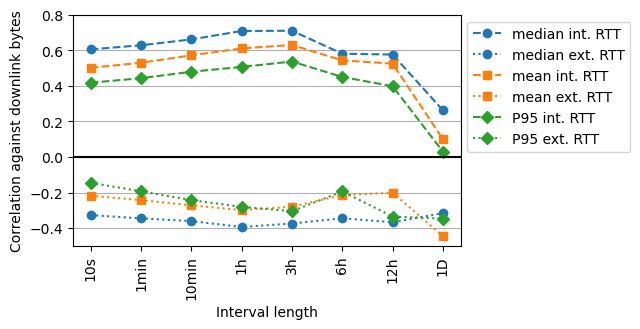

In [11]:
pretty_names = {"rtt_median_lan": "median int. RTT", 
                "rtt_mean_lan": "mean int. RTT", 
                "rtt_p95_lan": "P95 int. RTT",
                "rtt_median_wan": "median ext. RTT", 
                "rtt_mean_wan": "mean ext. RTT", 
                "rtt_p95_wan": "P95 ext. RTT"}

colors = {"median": "C0",
          "mean": "C1",
          "p95": "C2"}
linestyles = {"lan": "--",
              "wan": ":"}
#markers = {"lan": "^",
#           "wan": "v"}
markers = {"median": "o",
           "mean": "s",
           "p95": "D"}

fig, axes = plt.subplots(figsize=(5, 3))
x = np.arange(len(freqs))

for metric, cors in correlations.items():
    _, mtype, nside = metric.split("_")
    axes.plot(x, cors, label=pretty_names[metric], c=colors[mtype], 
              marker=markers[mtype], ls=linestyles[nside])

axes.set_xticks(x)
axes.set_xticklabels(freqs, rotation=90)
axes.legend(loc="upper left", bbox_to_anchor=[1, 1])
#axes.legend(loc="lower left", bbox_to_anchor=[0, 1])
axes.grid(axis="y")
axes.set_ylim(-0.5, 0.8)
axes.set_ylabel("Correlation against downlink bytes")
axes.set_xlabel("Interval length")
axes.axhline(0, c="k")

fig.savefig("figures/RTT_LANWAN_corr_multifreq-wide.pdf", 
            bbox_inches="tight")

<a id="internet-maps"></a>
### IPv4 Internet RTT maps

In [57]:
def _update_subnet_stats(to_stats, from_stats):
    to_stats["reports"] += from_stats["reports"]
    
    if from_stats["first_instance"] < to_stats["first_instance"]:
        to_stats["first_instance"] = from_stats["first_instance"]
    if from_stats["last_instance"] > to_stats["last_instance"]:
        to_stats["last_instance"] = from_stats["last_instance"]
    
    _update_rxtx_ttype_counters(to_stats["rx_stats"], from_stats["rx_stats"])
    _update_rxtx_ttype_counters(to_stats["tx_stats"], from_stats["tx_stats"])
    
    if from_stats["rtt_min"] is not None:
        if to_stats["rtt_min"] is None or from_stats["rtt_min"] < to_stats["rtt_min"]:
            to_stats["rtt_min"] = from_stats["rtt_min"]
        if to_stats["rtt_max"] is None or from_stats["rtt_max"] > to_stats["rtt_max"]:
            to_stats["rtt_max"] = from_stats["rtt_max"]
    
    add_to_histogram(to_stats["rtt_hist"], from_stats["rtt_hist"])

def _update_rxtx_ttype_counters(to_stats, from_stats):
    for ttype in from_stats.keys():
        
        if ttype in to_stats:
            for counter in from_stats[ttype]:
                to_stats[ttype][counter] += from_stats[ttype][counter]
        else:
            to_stats[ttype] = copy.deepcopy(from_stats[ttype])
    
    return to_stats

def _total_rxtx_ttype_counters(counters):
    pkt = 0
    byte = 0
    
    for ttype, counters in counters.items():
        pkt += counters.get("packets", 0)
        byte += counters.get("bytes", 0)
    
    return {"packets": pkt, "bytes": byte}

def merge_stats_for_subnet(subnet_data, target_subnet):
    subnets_merged = []
    subnet_stats = []
    target_subnet = ipaddress.ip_network(target_subnet)
    
    for subnet_str, stats in subnet_data.items():
        subnet = ipaddress.ip_network(subnet_str)
        if subnet.version == target_subnet.version and subnet.subnet_of(target_subnet):
            subnets_merged.append(subnet_str)
            subnet_stats.append(stats)
    
    merged_stats = merge_subnet_stats(subnet_stats)
    merged_stats["ip_version"] = target_subnet.version
    merged_stats["prefix_length"] = target_subnet.prefixlen
    merged_stats["merged_subnets"] = subnets_merged
    return merged_stats

def merge_subnet_stats(subnet_stats):
    merged_stats = _empty_subnet_stats()
    
    for stats in subnet_stats:
        _update_subnet_stats(merged_stats, stats)
    
    return merged_stats

def _empty_subnet_stats(nbins=250):
    return {"ip_version": 0,
            "prefix_length": 0,
            "type": "unknown",
            "reports": 0,
            "first_instance": 2**64 - 1,
            "last_instance": 0,
            "rx_stats": {},
            "tx_stats": {},
            "rtt_min": None,
            "rtt_max": None,
            "rtt_hist": [0] * nbins}

def agg_per_subnet(subnet_data, prefix_size, extract=None, 
                   subnet_range="0.0.0.0/0", aggfunc=np.sum):
    subnet_range = netify(subnet_range)
    subnet_agg = {ipnet: [] for ipnet in 
                  subnet_range.subnets(new_prefix=prefix_size)}
    
    for net, entry in subnet_data.items():
        supnet = netify(net).supernet(new_prefix=prefix_size)
        if supnet not in subnet_agg:
            continue
        
        if extract is None:
            val = entry
        else:
            val = extract(entry) if callable(extract) else entry[extract]
        subnet_agg[supnet].append(val)
    
    for subnet in list(subnet_agg.keys()):
        subnet_agg[subnet] = aggfunc(subnet_agg[subnet])
    
    return subnet_agg

def shortprefix_from_ipaddress(ip_address, prefix_len):
    ip_address = ipaddress.ip_address(ip_address)
    
    if ip_address.version == 4:        
        n_sections = int(np.ceil(prefix_len / 8))
        shortform = ".".join(ip_address.exploded.split(".")[:n_sections])
    else: # if version == 6
        n_chars = int(np.ceil(prefix_len / 4))
        if n_chars > 4:
            n_chars += (n_chars - 1) // 4 # Add space for the : inbetween groups
        shortform = ip_address.exploded[:n_chars]
    
    return shortform

def shortprefix_from_ipnetwork(ip_network):
    ip_network = netify(ip_network)
    return shortprefix_from_ipaddress(ip_network.network_address, ip_network.prefixlen)

def plot_internetmap(subnet_data, extract=None, aggfunc=np.sum, subnet_range="0.0.0.0/0", 
                     prefix_size=8, axes=None, label_prefix_size=None, label_kwargs=None, 
                     **kwargs):
    if prefix_size < 2 or prefix_size % 2 != 0:
        raise ValueError("Not possible to create an internet map with prefix_size {}".format(prefix_size))
    if axes is None:
        axes = plt.gca()
    if label_prefix_size == "same":
        label_prefix_size = prefix_size
    if label_kwargs is None:
        label_kwargs = dict()
    
    agg = agg_per_subnet(subnet_data, prefix_size, subnet_range=subnet_range, 
                         extract=extract, aggfunc=aggfunc)
    
    #print(agg)
    
    if label_prefix_size == prefix_size:
        labels = as_hilbert_matrix([shortprefix_from_ipnetwork(net) 
                                    for net in agg.keys()])
        grid = True
        if "fontsize" in label_kwargs:
            kwargs["fontsize"] = label_kwargs["fontsize"]
    else:
        labels = None
        grid = False
    plot_heatmap(as_hilbert_matrix(list(agg.values())), labels=labels, grid=grid, **kwargs)
    
    if label_prefix_size is not None and label_prefix_size != prefix_size:
        lkwa = {"fontsize": 6}
        lkwa.update(label_kwargs)
        internetmap_prefix_overlay(axes, label_prefix_size, subnet_range=subnet_range, 
                                   **lkwa)
    return agg

def internetmap_prefix_overlay(axes, prefix_size, subnet_range="0.0.0.0/0", 
                               xoff=0, yoff=0, grid_kwargs=None, **kwargs):
    if prefix_size < 2 or prefix_size % 2 != 0:
        raise ValueError("Not possible to overlay an internet map with prefix_size {}".format(prefix_size))
    
    subnet_range = ipaddress.ip_network(subnet_range)
    labels = subnet_range.subnets(new_prefix=prefix_size)
    labels = as_hilbert_matrix([shortprefix_from_ipnetwork(net) for net in labels])
    
    map_size = int(np.ceil(axes.get_xlim()[1]))
    ol_size = 2**(prefix_size / 2)
    step_size = map_size / ol_size
    init_off = step_size / 2 - 0.5
    
    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            axes.text((x + xoff) * step_size + init_off, 
                      (y + yoff) * step_size + init_off, labels[y, x], 
                      va="center", ha="center", **kwargs)
    
    if grid_kwargs is None:
        grid_kwargs = dict()
    grid_heatmap(axes, step_size=step_size, **grid_kwargs)
    
    return labels

In [58]:
%%time
with open("data/processed/subnet_stats_merged.json", "rt") as f:
    subnet_data = json.load(f)
    
wan4_subnets = {net: stats for net, stats in subnet_data.items() 
                if stats["type"] == "WAN" and stats["ip_version"] == 4}

CPU times: user 8.72 s, sys: 424 ms, total: 9.15 s
Wall time: 9.14 s


In [59]:
bins = np.arange(0, 1001, 4)

rtt_agg_funcs = [
    ("Median RTT (ms)", lambda x: x["rtt_hist"], 
     lambda x: bincount_median(bins, sum_histograms(x))),
    ("Mean RTT (ms)", lambda x: x["rtt_hist"], 
     lambda x: bincount_median(bins, sum_histograms(x))),
    ("P95 RTT (ms)", lambda x: x["rtt_hist"], 
     lambda x: bincount_quantile(bins, sum_histograms(x), 0.95)),
    ("RTT std (ms)", lambda x: x["rtt_hist"], 
     lambda x: bincount_std(bins, sum_histograms(x)))
]

In [60]:
subnet8_stats = agg_per_subnet(wan4_subnets, prefix_size=8, aggfunc=merge_subnet_stats)

Median RTT (ms)
Mean RTT (ms)
P95 RTT (ms)
RTT std (ms)


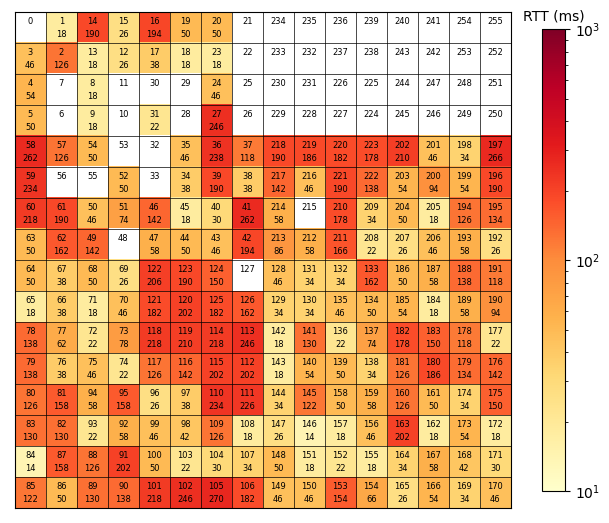

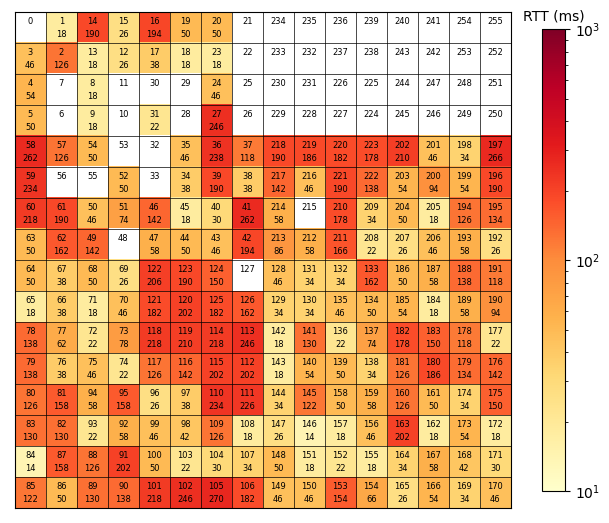

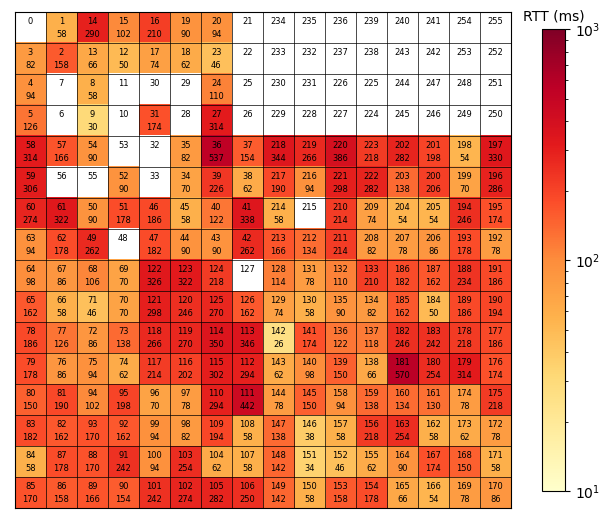

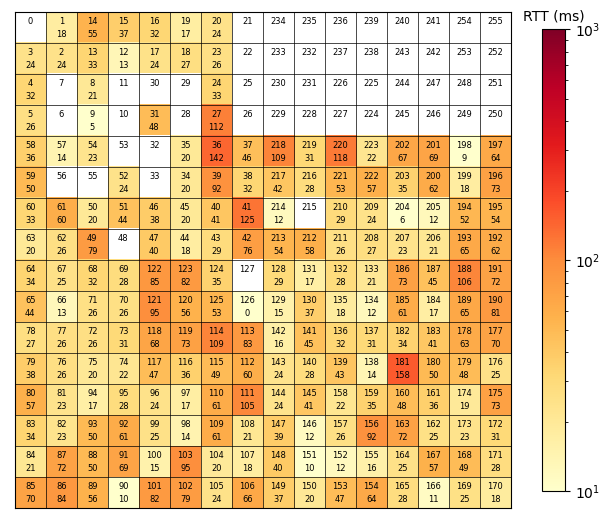

In [61]:
# With fixed log-scale between 10-1000ms
def no_nans_formatter(val):
    return "" if np.isnan(val) else "{:.0f}".format(val) 

for stat_name, extractor, aggfunc in rtt_agg_funcs:
    print(stat_name)
    fig, axes = plt.subplots(figsize=(8, 8))
    plot_internetmap(subnet8_stats, prefix_size=8, axes=axes, aggfunc=aggfunc,
                     extract=extractor, label_prefix_size="same", cbar_label=None,
                     norm=mcolors.LogNorm(vmin=10, vmax=1000, clip=True), 
                     val_fmt=no_nans_formatter, cbar_size=0.75)
    axes.images[-1].colorbar.ax.set_title("RTT (ms)", fontsize=10)
    
    # Uncomment to plot Hilbert curve on top
    # xy = np.array(HilbertCurve(4, 2).points_from_distances(np.arange(256)))
    # axes.plot(xy[:,0], xy[:,1], alpha=0.4)
    
    stat_name_n = stat_name.replace(" ", "-")
    fig.savefig("figures/internetmap8-{}_fixedcolor_log.pdf".format(stat_name_n), 
                dpi=300, bbox_inches="tight")

<a id="subnet-rtt-metrics"></a>
### RTT metrics per subnet

In [2]:
def make_subnet_agged_dataframe(stats_per_subnet):    
    subnets = list(stats_per_subnet.keys())
    records = [_flatten_merged_stats_record(stats_per_subnet[subnet]) 
               for subnet in subnets]
    
    df = pd.DataFrame.from_records(records)
    df.insert(0, "subnet", subnets)
    df.sort_values("subnet", inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # convert from ns to ms
    df["rtt_min"] /= 1e6
    df["rtt_max"] /= 1e6
    
    return df

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

def compute_rtt_metrics_for_hists(hists, bins, 
                                  metrics=["count", "mean", "median", "p95", "p99"], 
                                  histfunc_map=None):
    funcmap = {
        "count": bincount_count,
        "min": bincount_min,
        "mean": bincount_mean,
        "median": bincount_median,
        "p25": lambda b, c: bincount_quantile(b, c, 0.25),
        "p75": lambda b, c: bincount_quantile(b, c, 0.75),
        "p95": lambda b, c: bincount_quantile(b, c, 0.95),
        "p99": lambda b, c: bincount_quantile(b, c, 0.99),
        "p1p99": lambda b, c: bincount_quantile(b, c, 0.99) - bincount_quantile(b, c, 0.01),
        "max": bincount_max,
        "std": bincount_std,
        "iqr": bincount_iqr}

    
    if histfunc_map is not None:
        funcmap.update(histfunc_map)
    
    stats = {}
    for metric in metrics:
        stats["rtt_" + metric] = [funcmap[metric.lower()](bins, hist) 
                                  for hist in hists]

    return stats

def subnetstr_to_ip(subnet_str):
    return subnet_str.rsplit("/")[0]


In [3]:
%%time
with open("data/processed/subnet_stats_merged.json") as jfile:
    subnet_stats = json.load(jfile)

CPU times: user 4.74 s, sys: 426 ms, total: 5.16 s
Wall time: 5.16 s


In [4]:
%%time
df = make_subnet_agged_dataframe(subnet_stats)
wan_df = df.loc[np.logical_or(df["type"] == "WAN", df["subnet"].str.contains("/0"))].copy()

CPU times: user 6.07 s, sys: 272 ms, total: 6.34 s
Wall time: 6.34 s


In [5]:
%%time
bins = np.arange(0, 1001, 4)
rtt_metrics = ["count", "p25", "median", "mean", "p75", 
               "p95", "p99", "p1p99", "iqr", "std"]

for col, vals in (compute_rtt_metrics_for_hists(
    wan_df["rtt_hist"].values, bins=bins, metrics=rtt_metrics).items()):
    wan_df[col] = vals

CPU times: user 1min 54s, sys: 4.49 ms, total: 1min 54s
Wall time: 1min 54s


In [6]:
%%time
funcmap = {
    "count": bincount_count,
    "min": bincount_min,
    "mean": bincount_mean,
    "median": bincount_median,
    "p25": lambda b, c: bincount_quantile(b, c, 0.25),
    "p75": lambda b, c: bincount_quantile(b, c, 0.75),
    "p95": lambda b, c: bincount_quantile(b, c, 0.95),
    "p99": lambda b, c: bincount_quantile(b, c, 0.99),
    "p1p99": lambda b, c: bincount_quantile(b, c, 0.99) - bincount_quantile(b, c, 0.01),
    "max": bincount_max,
    "std": bincount_std,
    "iqr": bincount_iqr
}

tot_hist = sum_histograms(wan_df["rtt_hist"].values)

glob_vals = {"rtt_min": wan_df["rtt_min"].min(), 
             "rtt_max": wan_df["rtt_max"].max()}

for metric in rtt_metrics:
    glob_vals["rtt_" + metric] = funcmap[metric](bins, tot_hist)

CPU times: user 3.39 s, sys: 21 µs, total: 3.39 s
Wall time: 3.39 s


rtt_median: glob y = 0.12025630268126168
rtt_mean: glob y = 0.10071576592038853
rtt_p95: glob y = 0.5442617948815744
rtt_p99: glob y = 0.8252666641239813
rtt_std: glob y = 0.9059079293642015
rtt_iqr: glob y = 0.9674917680562442
rtt_p1p99: glob y = 0.9418360730767764


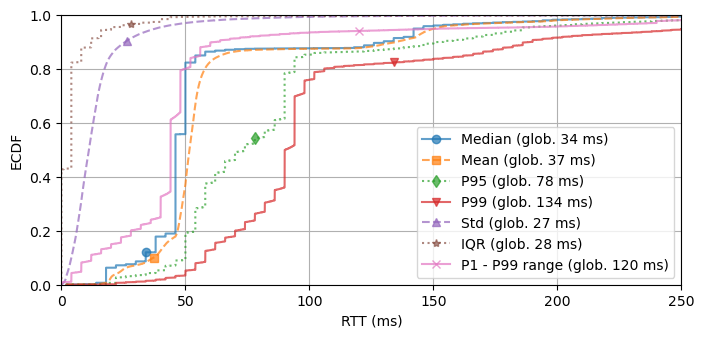

In [7]:
cols = ["rtt_median", "rtt_mean", "rtt_p95", "rtt_p99", "rtt_std", "rtt_iqr", "rtt_p1p99"]
pretty_names = {col: col.split("_")[1].capitalize() for col in cols}
pretty_names["rtt_iqr"] = "IQR"
pretty_names["rtt_p1p99"] = "P1 - P99 range"
wan_df_filt = wan_df.query("rtt_count >= 100")

colors=["C" + str(i) for i in range(len(cols))]
ls = np.tile(["-", "--", ":"], 3)
markers=["o", "s", "d", "v", "^", "*", "x"]

fig, axes = plt.subplots(figsize=(8, 3.5))
for i, col in enumerate(cols):
    
    x = glob_vals[col]
    vals = wan_df_filt[col].values[wan_df_filt[col].notnull()]
    y = (vals <= x).sum() / len(vals)
    print("{}: glob y = {}".format(col, y))
    
    plot_ecdf(*ecdf(wan_df_filt[col].values), c=colors[i], ls=ls[i], alpha=0.7)
    axes.plot([x], [y], c=colors[i], ls=ls[i], marker=markers[i], alpha=0.7,
              label="{} (glob. {:.0f} ms)".format(pretty_names[col], x))

axes.legend()
axes.grid()
axes.set_ylim(0, 1)
axes.set_xlim(0, 250)
axes.set_xlabel("RTT (ms)")
axes.set_ylabel("ECDF")

fig.savefig("figures/RTT_metrics_per_subnet.pdf", bbox_inches="tight")

<a id="top-as"></a>
### RTT for most common ASes

In [71]:
def make_subnet_agged_dataframe(stats_per_subnet):    
    subnets = list(stats_per_subnet.keys())
    records = [_flatten_merged_stats_record(stats_per_subnet[subnet]) 
               for subnet in subnets]
    
    df = pd.DataFrame.from_records(records)
    df.insert(0, "subnet", subnets)
    df.sort_values("subnet", inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # convert from ns to ms
    df["rtt_min"] /= 1e6
    df["rtt_max"] /= 1e6
    
    return df

def _flatten_merged_stats_record(stats):
    
    flat = {col: np.nan if val is None else val 
            for col, val in stats.items() if np.isscalar(val)}
    
    for col, val in _flatten_ttype_counters(stats["rx_stats"]).items():
        flat["rx_" + col] = val
    for col, val in _flatten_ttype_counters(stats["tx_stats"]).items():
        flat["tx_" + col] = val
    
    flat["rtt_hist"] = [b for b in stats["rtt_hist"]]
    #flat["rtt_hist"] = np.array(stats["rtt_hist"])
    
    return flat

def _flatten_ttype_counters(ttype_counters):
    
    def _get_counter(counters, ttype, counter):
        return counters.get(ttype, {}).get(counter, 0)
    
    flat = {}
    for counter in ("packets", "bytes"):
        flat["tcp_ts_" + counter] = _get_counter(ttype_counters, 
                                                 "TCP_TS", counter)
        
        flat["tcp_" + counter] = (flat["tcp_ts_" + counter] + 
                                  _get_counter(ttype_counters, "TCP_noTS", 
                                               counter))
        flat[counter] = (flat["tcp_" + counter] + 
                         _get_counter(ttype_counters, "other", counter))
    
    return flat

def compute_rtt_metrics_for_hists(hists, bins, 
                                  metrics=["count", "mean", "median", "p95", "p99"], 
                                  histfunc_map=None):
    funcmap = {
        "count": bincount_count,
        "min": bincount_min,
        "mean": bincount_mean,
        "median": bincount_median,
        "p25": lambda b, c: bincount_quantile(b, c, 0.25),
        "p75": lambda b, c: bincount_quantile(b, c, 0.75),
        "p95": lambda b, c: bincount_quantile(b, c, 0.95),
        "p99": lambda b, c: bincount_quantile(b, c, 0.99),
        "p1p99": lambda b, c: bincount_quantile(b, c, 0.99) - bincount_quantile(b, c, 0.01),
        "max": bincount_max,
        "std": bincount_std,
        "iqr": bincount_iqr}

    
    if histfunc_map is not None:
        funcmap.update(histfunc_map)
    
    stats = {}
    for metric in metrics:
        stats["rtt_" + metric] = [funcmap[metric.lower()](bins, hist) 
                                  for hist in hists]
    
    #stats = {"rtt_" + metric: [] for metric in metrics}
    #for hist in hists:
    #    for metric in metrics:
    #        stats["rtt_" + metric].append(funcmap[metric](bins, hist))
    
    return stats

def subnetstr_to_ip(subnet_str):
    return subnet_str.rsplit("/")[0]

def subnet_to_asn(subnet, asndb):
    subnet = str(subnet)
    if subnet.endswith("/0"):
        return -2 # Special "error code" for the fallback entries
    asn = asndb.lookup(subnetstr_to_ip(subnet))[0]
    if asn is None:
        return -1
    return asn

def parse_asn_txt(filename):
    "parses asn.txt from https://ftp.ripe.net/ripe/asnames/asn.txt"
    asn_name_map = {}
    with open(filename) as f:
        for line in f:
            asn, info = line.split(maxsplit=1)
            name = info.split(",")[0]
            asn_name_map[int(asn)] = name
    
    return asn_name_map

def get_top_entries(df, groupby="subnet", rankby="rx_bytes", 
                    aggfunc="sum", n=50, highest_vals=True, norm=False, 
                    norm_percent=False):
    vals = df.groupby(groupby)[rankby].agg(aggfunc)
    vals_top = vals.sort_values(ascending=not highest_vals).iloc[:n]
    if norm:
        vals_top = (vals_top / vals.sum()) * (100 if norm_percent else 1)
    
    return vals_top

def agg_rtts_groupby(df, groupby, rtt_metrics=None, bins=None, **kwargs):
    gb = df.groupby(groupby, **kwargs)
    index = gb.size().index
    data = {"rtt_min": gb["rtt_min"].min().values,
            "rtt_max": gb["rtt_max"].max().values,
            "rtt_hist": gb["rtt_hist"].apply(sum_histograms).values}
    
    if rtt_metrics is not None and bins is not None:
        for col, vals in compute_rtt_metrics_for_hists(gb_df["rtt_hist"], 
                                                       bins, metrics=rtt_metrics):
            if col not in ("rtt_min", "rtt_max"):
                data[col] = vals
    
    return pd.DataFrame(data, index=index)

# From https://stackoverflow.com/questions/67239317/how-to-convert-number-to-compact-format-in-python-for-charting
def human_format(num, round_to=1):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num = round(num / 1000.0, round_to)
    abbr = ['', 'K', 'M', 'G', 'T', 'P'][magnitude]
    return f'{num:.{round_to}f}{abbr}'

def plot_rtt_histogram(rtts, bins=np.arange(0, 1001, 4), axes=None, 
                       legend=True, legend_include_stat=True, 
                       legend_kwargs={}, count_rtts=True):
    if axes is None:
        axes = plt.gca()
    
    rtts = np.array(rtts)
    n = sum(rtts)

    axes.bar(get_bin_centers(bins), rtts / max(n, 1), width=np.diff(bins))

    ylim = axes.get_ylim()
    for func, name, ls in zip((bincount_mean, bincount_median, 
                                  lambda b, c: bincount_quantile(b, c, 0.95),
                                  lambda b, c: bincount_quantile(b, c, 0.99)), 
                                 ("mean", "median", "P95", "P99"), ("-", "--", ":", (0, (1, 5)))):
        x = func(bins, rtts)
        label = name
        if legend_include_stat:
            label += " ({:0f} ms)".format(x)
        axes.plot([x, x], [-1e99, 1e99], c="k", ls=ls, label=label)
    axes.set_ylim(*ylim)
    
    if count_rtts:
        axes.text(0.99, 0.98, "{} RTTs".format(human_format(n, round_to=0)), 
                  ha="right", va="top", transform=axes.transAxes)

    axes.grid()
    if legend:
        axes.legend(**legend_kwargs)

    axes.set_ylabel("Frequency (normalized)")
    axes.set_xlabel("RTT (ms)")
    axes.set_xlim(0, 150)
    
    return axes

In [72]:
%%time
with open("data/processed/subnet_stats_merged.json") as jfile:
    subnet_stats = json.load(jfile)

df = make_subnet_agged_dataframe(subnet_stats)
wan_df = df.loc[np.logical_or(df["type"] == "WAN", df["subnet"].str.contains("/0"))].copy()

wan_df["rtt_count"] = compute_rtt_metrics_for_hists(wan_df["rtt_hist"].values, 
                                                    bins=np.arange(0, 1001, 4), 
                                                    metrics=["count"])["rtt_count"]

CPU times: user 17.2 s, sys: 180 ms, total: 17.4 s
Wall time: 17.4 s


In [73]:
asndb = pyasn.pyasn("data/rrc14_20231115_ipasn.dat")
asn2name_map = parse_asn_txt("data/asn.txt")
wan_df["asn"] = [subnet_to_asn(subnet, asndb) for subnet in wan_df["subnet"]]

In [74]:
# Precompute some data to use for later filtering of ASNs from raw-data
asn_map = {row.subnet: row.asn for row in wan_df.itertuples()}
with open("data/processed/subnet_to_asn_map.json", "wt") as outfile:
    json.dump(asn_map, outfile)
    
top100asn = get_top_entries(wan_df, groupby="asn", rankby="rx_bytes", n=100, norm=True)
print(top100asn.sum())
with open("data/processed/top100asn_list.json", "wt") as outfile:
    json.dump(top100asn.index.to_list(), outfile)

0.9976741179047216


#### Individual histograms

/home/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


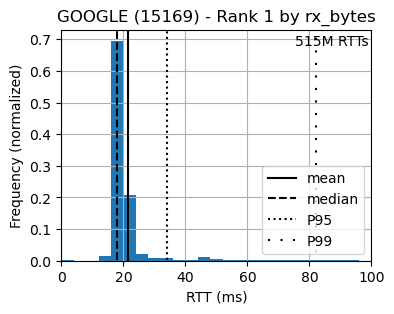

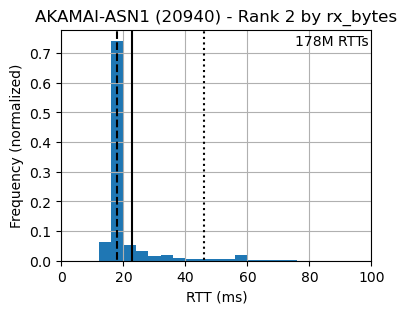

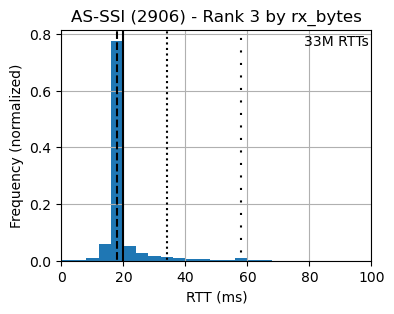

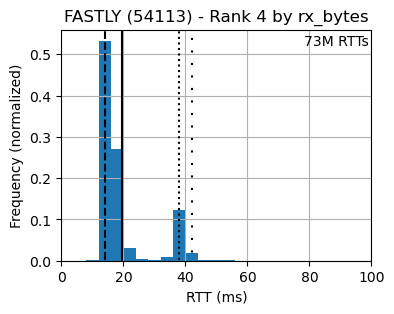

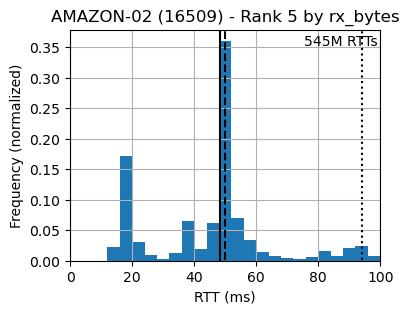

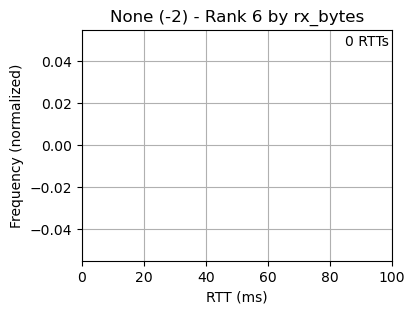

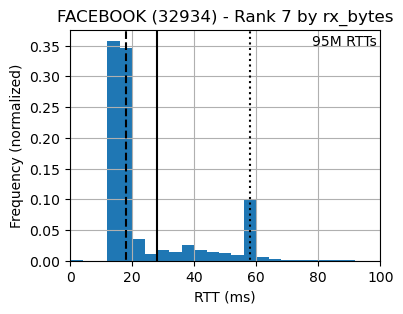

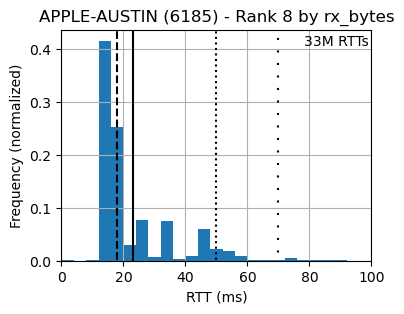

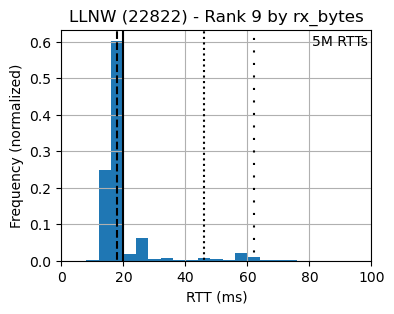

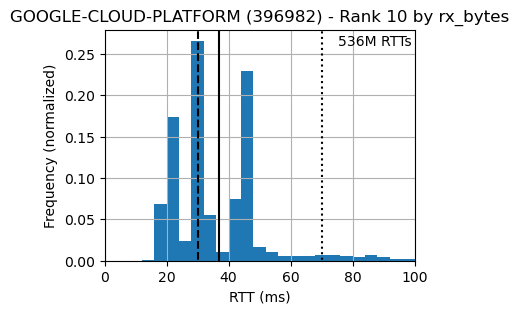

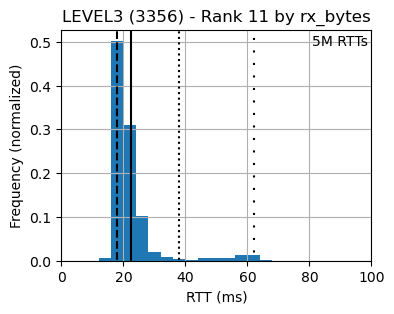

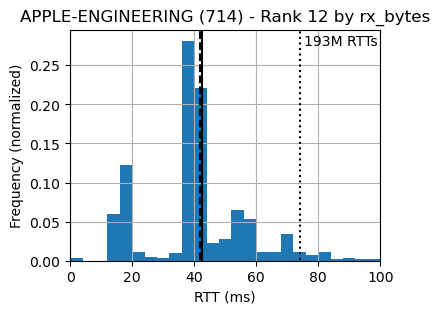

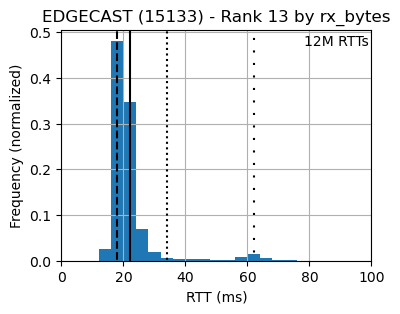

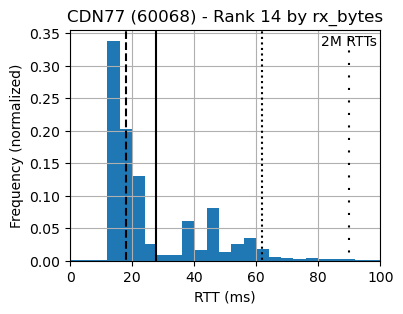

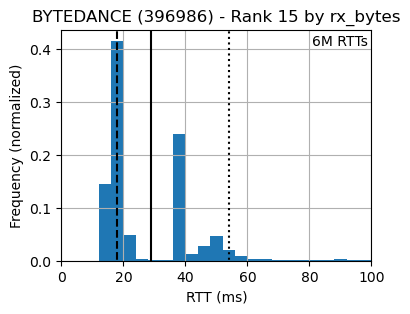

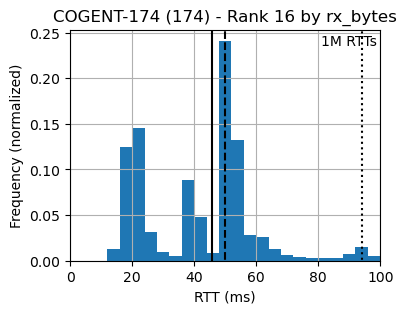

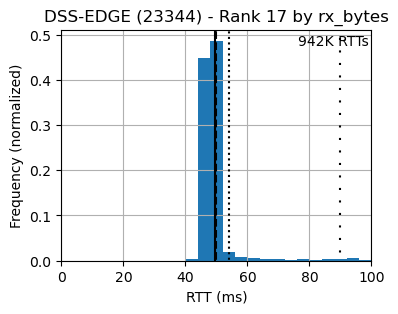

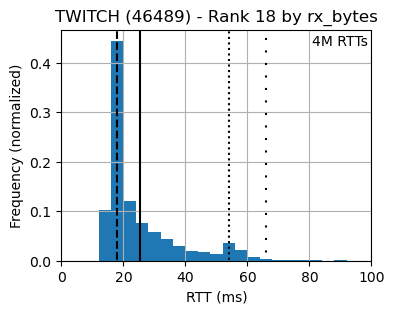

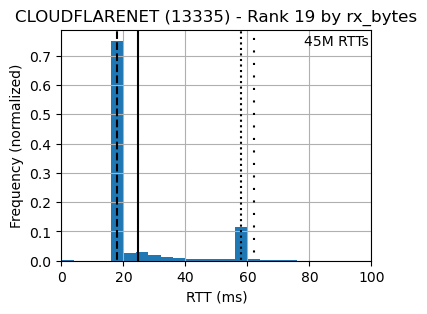

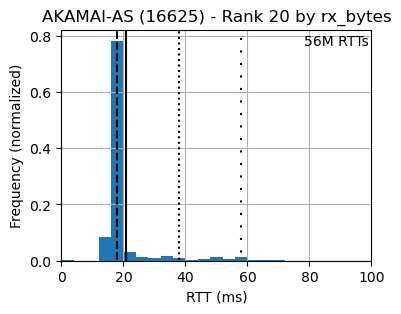

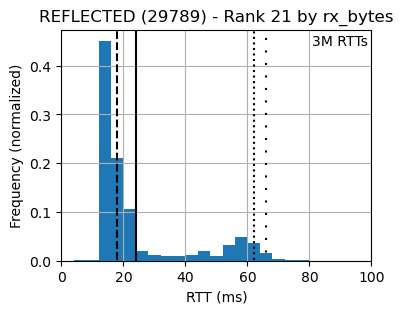

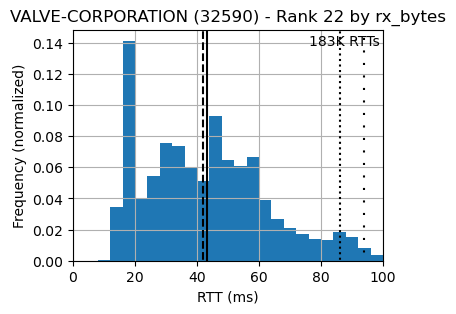

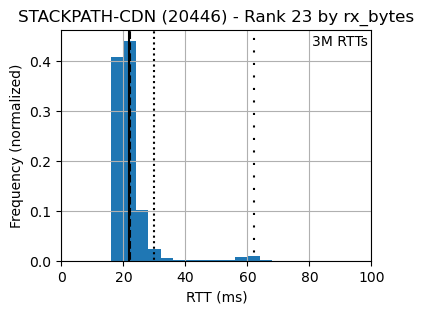

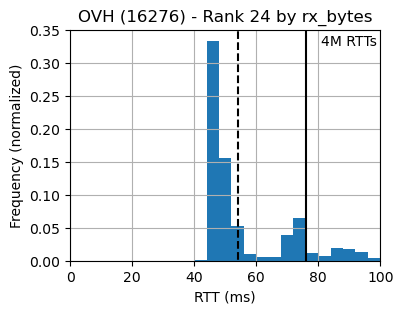

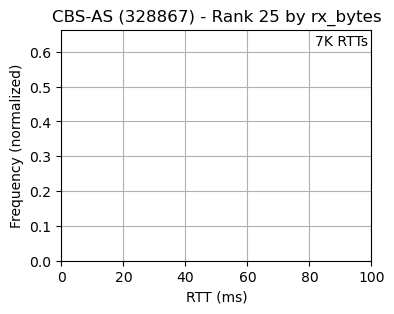

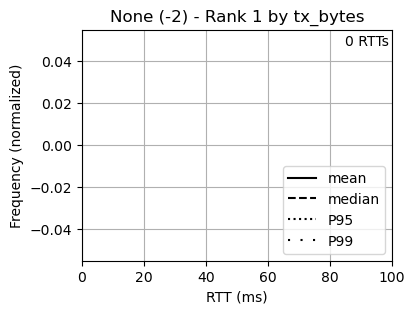

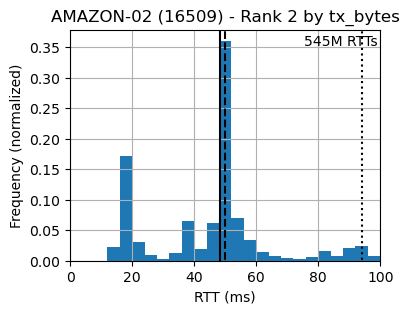

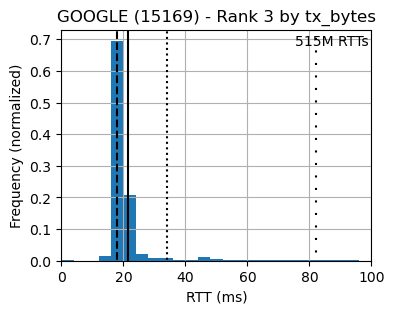

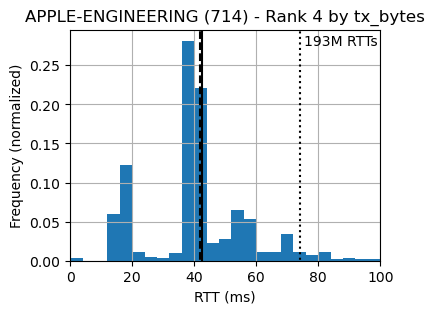

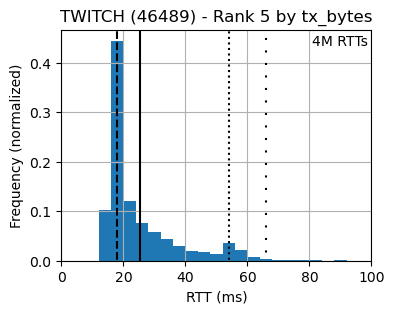

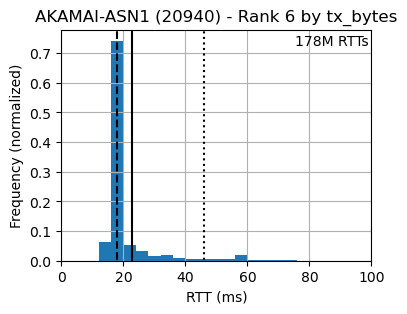

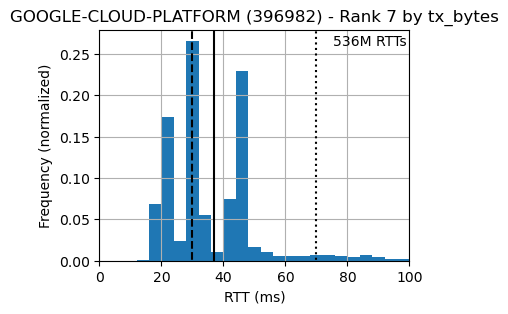

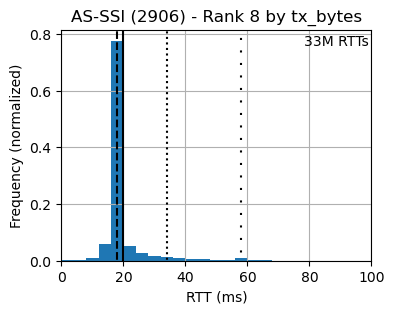

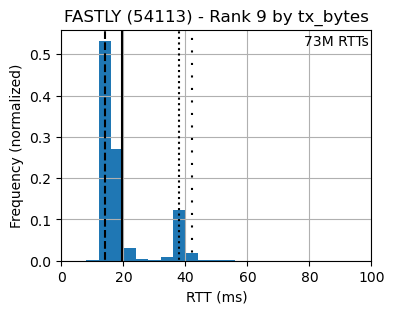

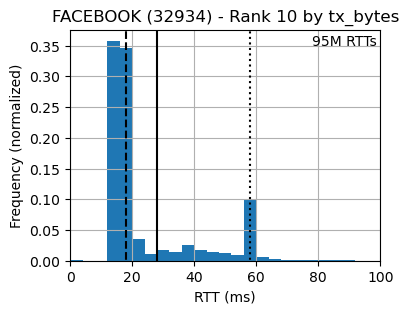

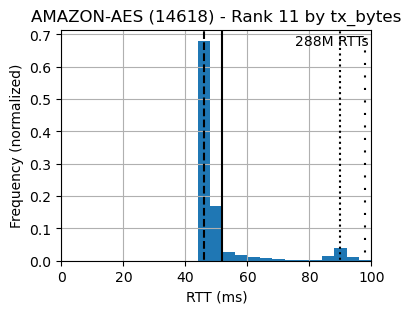

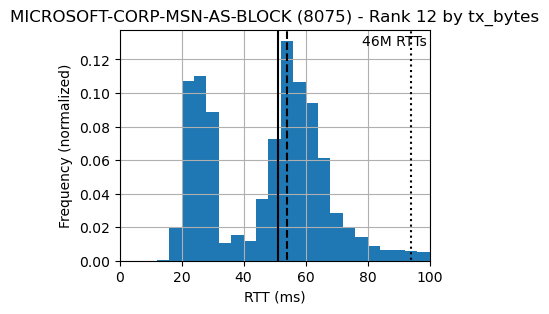

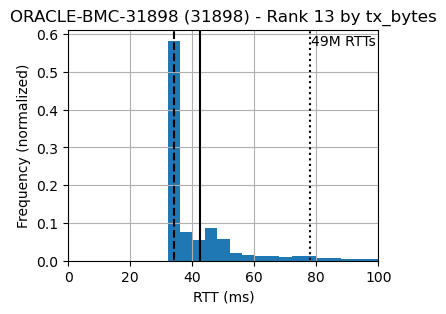

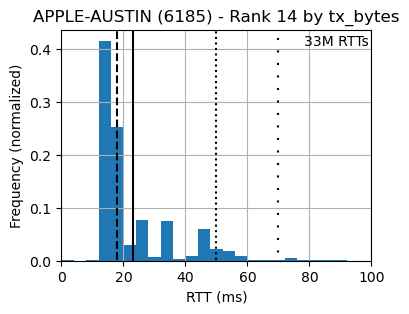

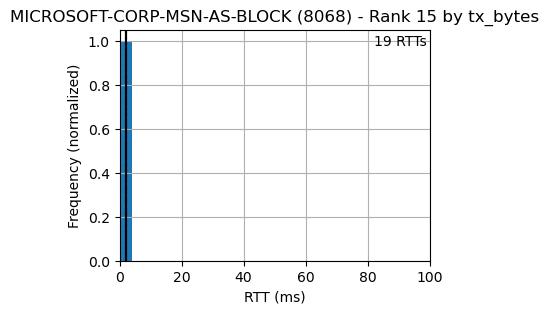

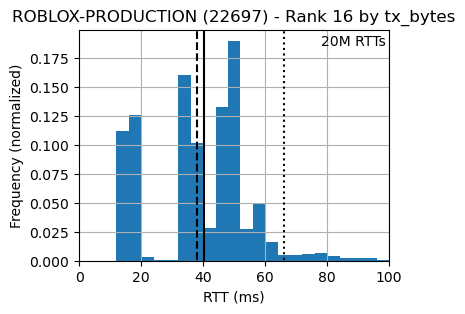

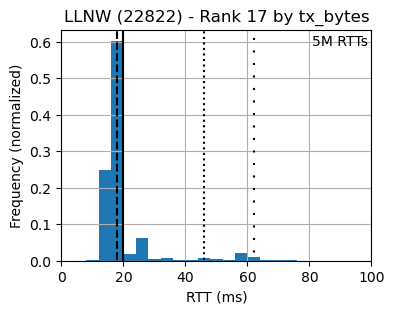

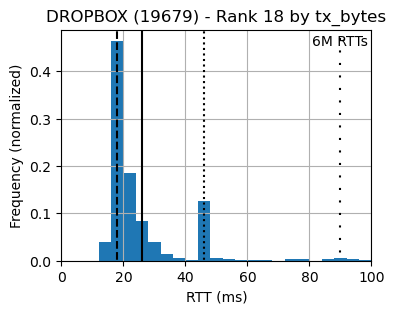

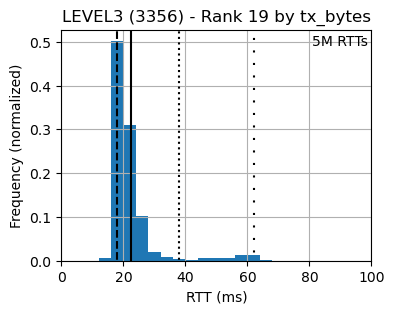

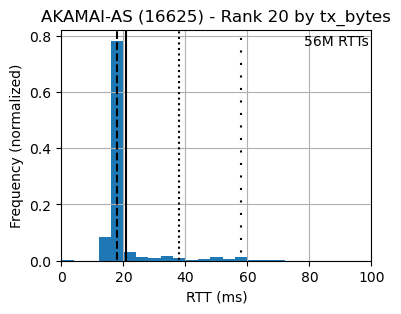

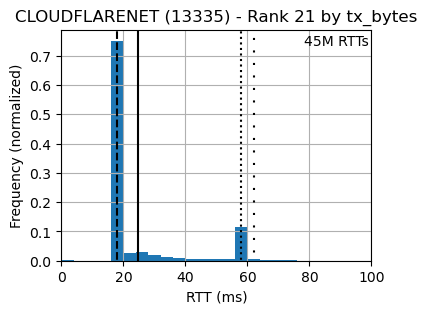

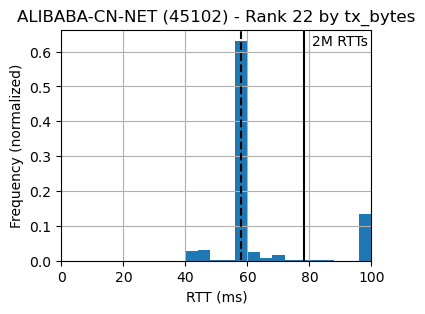

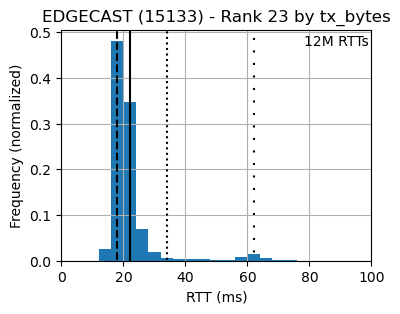

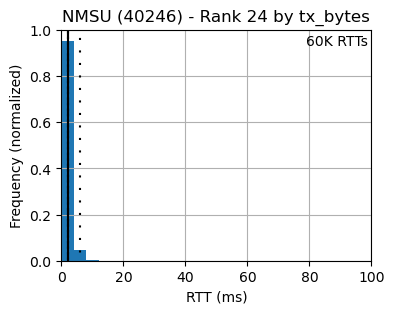

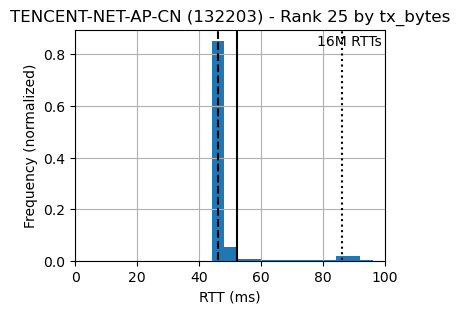

In [75]:
groupby = "asn"
agg_rtts = agg_rtts_groupby(wan_df, groupby)
bins = np.arange(0, 1001, 4)

for rankby in ["rx_bytes", "tx_bytes"]:
    top_n = get_top_entries(wan_df, groupby, rankby, n=25, norm=True)
    #top_n = top_n.loc[top_n.index >= 0]
    
    for i, grp in enumerate(top_n.index):
        fig, axes = plt.subplots(figsize=(4, 3))
        rtts = agg_rtts.loc[grp]
        plot_rtt_histogram(rtts["rtt_hist"], axes=axes, legend=(i == 0), 
                           legend_include_stat=False, legend_kwargs={"loc": "lower right"})
        
        asname = asn2name_map.get(grp, "None").split()[0]
        axes.set_title("{} ({}) - Rank {} by {}".format(asname, grp, i+1, rankby)) # Comment out for paper subfigs
        axes.set_xlim(0, 100)
        
        asname = asn2name_map.get(grp, "None").split()[0]
        fig.savefig("figures/ASN_histograms/RTT_hist_top_{}_by_{}_{}_{}.pdf".format(
            groupby, rankby, i+1, asname), bbox_inches="tight")
        
        #plt.close(fig)

#### Joint barchart + boxplot

In [76]:
def top_n_barplot(df, groupby=None, rankby=None, n=20, norm=True, 
                  precomputed=False, axes=None, x_off=0, width=0.8,
                  label_rotation=45):
    if axes is None:
        axes = plt.gca()
    
    if precomputed:
        top_n = df
    elif not (groupby is None or rankby is None):
        top_n = get_top_entries(df, groupby, rankby, n=n, norm=norm)
    else:
        raise ValueError("If not precomputed, groupby and rankby must be provided")
    
    axes.bar(np.arange(len(top_n)) + x_off, top_n.values, width=width)
    
    axes.set_xticks(np.arange(len(top_n)))
    axes.set_xticklabels(top_n.index, rotation=label_rotation, 
                         rotation_mode="anchor", va="top", ha="right")
    
    return top_n

def top_n_boxplot(df, groupby=None, rankby=None, n=20, precomputed=False, 
                  axes=None, bins=np.arange(0, 1001, 4), whiskers=(0.01, 0.99), 
                  quantiles=(), show_minmax=False, x_off=0, width=0.5, 
                  label_rotation=45, quantile_kwargs={}, **kwargs):
    if axes is None:
        axes = plt.gca()
    
    if precomputed:
        rtt_data = df
    elif not (groupby is None or rankby is None):
        top_n = get_top_entries(df, groupby, rankby, n=n)
        rtt_data = agg_rtts_groupby(df, groupby, bins=bins).loc[top_n.index]
    else:
        raise ValueError("If not precomputed, groupby and rankby must be provided")
    
    x = np.arange(len(rtt_data)) + x_off
    bxp_info = [gen_boxplot_dict(row.rtt_hist, fliers=[row.rtt_min, row.rtt_max], 
                                 whislo=whiskers[0], whishi=whiskers[1], bins=bins) 
                for row in rtt_data.itertuples()]
    axes.bxp(bxp_info, x, widths=width, showfliers=show_minmax, **kwargs)
    
    qkwargs = {"color": "k", "width": width * 0.7}
    qkwargs.update(quantile_kwargs)
    for q in quantiles:
        y = [bincount_quantile(bins, row.rtt_hist, q) 
             for row in rtt_data.itertuples()]
        plot_horizontal_ticks(x, y, axes=axes, **qkwargs)
    
    axes.set_xticks(np.arange(len(rtt_data)))
    axes.set_xticklabels(rtt_data.index, rotation=label_rotation, 
                         rotation_mode="anchor", va="top", ha="right")
    
    return rtt_data

def gen_boxplot_dict(hist, fliers=[], whislo=0.01, whishi=0.99, bins=np.arange(0, 1001, 4)):
    return {"med": bincount_median(bins, hist),
            "q1": bincount_quantile(bins, hist, 0.25),
            "q3": bincount_quantile(bins, hist, 0.75),
            "mean": bincount_mean(bins, hist),
            "whislo": None if whislo is None else bincount_quantile(bins, hist, whislo),
            "whishi": None if whishi is None else bincount_quantile(bins, hist, whishi),
            "fliers": fliers}

def plot_horizontal_ticks(x, y, width=0.5, axes=None, **kwargs):
    if axes is None:
        axes = plt.gca()
    
    tick_x = np.full(len(x) * 3, np.nan)
    tick_x[0::3] = np.array(x) - width/2
    tick_x[1::3] = np.array(x) + width/2
    tick_y = np.repeat(y, 3)
    axes.plot(tick_x, tick_y, **kwargs)

Skipping:


asn
-2    7.067098
Name: rx_bytes, dtype: float64

Fraction traffic covered: 89.52719500050715


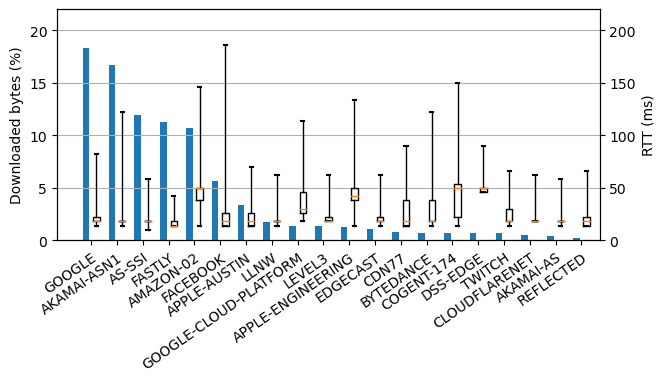

In [77]:
groupby = "asn"
agg_rtts = agg_rtts_groupby(wan_df, groupby)
bins = np.arange(0, 1001, 4)
rankby = "rx_bytes"
ylabel = "Downloaded bytes (%)"

top_n = get_top_entries(wan_df, groupby, rankby, n=30, norm=True, 
                        norm_percent=True)

mask = top_n.index.isin(wan_df.query("rtt_count >= 10000")["asn"].values)
print("Skipping:") 
display(top_n.iloc[:20].loc[np.logical_not(mask[:20])])
    
top_n = top_n.loc[mask].iloc[:20]
print("Fraction traffic covered:", top_n.sum())
rtt_data = agg_rtts.loc[top_n.index]

fig, ax = plt.subplots(figsize=(7, 3))
ax2 = ax.twinx()
top_n_barplot(top_n, precomputed=True, axes=ax, x_off=-0.2, width=0.25)
top_n_boxplot(rtt_data, precomputed=True, axes=ax2, x_off=0.2, width=0.25, 
              #quantiles=(0.1, 0.9), 
              show_minmax=False, whiskers=(0.01, 0.99),
              flierprops={"markerfacecolor":"k", "markersize": 4},
              quantile_kwargs={"color": "C3"},
              capprops={"linewidth": 1.5})

ax.grid(axis="y")
ax.set_ylabel(ylabel)
ax2.set_ylabel("RTT (ms)")
ax.set_xticklabels([asn2name_map.get(asn, "None").split()[0] 
                    for asn in top_n.index], rotation=35, 
                   rotation_mode="anchor", va="top", ha="right")
ax.set_ylim(0, 22)
ax2.set_ylim(0, 220)

fig.savefig("figures/top20_{}_{}_barbox.pdf".format(
    groupby, rankby), bbox_inches="tight")

Skipping:


asn
-2       25.911742
 8068     0.422447
Name: tx_bytes, dtype: float64

Fraction traffic covered: 69.35436555337317


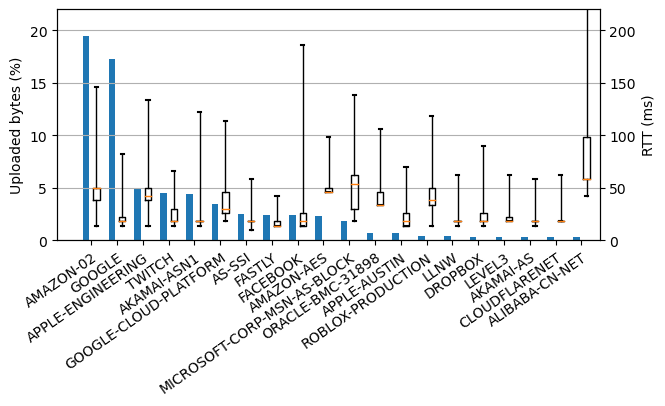

In [78]:
groupby = "asn"
agg_rtts = agg_rtts_groupby(wan_df, groupby)
bins = np.arange(0, 1001, 4)
rankby = "tx_bytes"
ylabel = "Uploaded bytes (%)"

top_n = get_top_entries(wan_df, groupby, rankby, n=22, norm=True, 
                        norm_percent=True)

mask = top_n.index.isin(wan_df.query("rtt_count >= 10000")["asn"].values)
print("Skipping:") 
display(top_n.iloc[:20].loc[np.logical_not(mask[:20])])
    
top_n = top_n.loc[mask].iloc[:20]
print("Fraction traffic covered:", top_n.sum())
rtt_data = agg_rtts.loc[top_n.index]

fig, ax = plt.subplots(figsize=(7, 3))
ax2 = ax.twinx()
top_n_barplot(top_n, precomputed=True, axes=ax, x_off=-0.2, width=0.25)
top_n_boxplot(rtt_data, precomputed=True, axes=ax2, x_off=0.2, width=0.25, 
              #quantiles=(0.1, 0.9), 
              show_minmax=False, whiskers=(0.01, 0.99),
              flierprops={"markerfacecolor":"k", "markersize": 4},
              quantile_kwargs={"color": "C3"},
              capprops={"linewidth": 1.5})

ax.grid(axis="y")
ax.set_ylabel(ylabel)
ax2.set_ylabel("RTT (ms)")
ax.set_xticklabels([asn2name_map.get(asn, "None").split()[0] 
                    for asn in top_n.index], rotation=35, 
                   rotation_mode="anchor", va="top", ha="right")
ax.set_ylim(0, 22)
ax2.set_ylim(0, 220)

fig.savefig("figures/top20_{}_{}_barbox.pdf".format(
    groupby, rankby), bbox_inches="tight")

#### ASN RTT variation over time